# K-Means Clustering: Global Candidates
Clustering candidates into 3 levels: Strong, Average, Weak based on Stack Overflow metrics

## Theoretical Foundation: How Candidates Are Classified

### 1. **K-Means Clustering Algorithm**
K-Means is an unsupervised machine learning algorithm that partitions data into K clusters by:
- Initializing K random cluster centers
- Assigning each point to the nearest cluster center
- Recalculating cluster centers as the mean of assigned points
- Iterating until convergence (minimal change in cluster centers)

**Objective Function (Minimizing WCSS):**
$$\text{Minimize} \sum_{i=1}^{K} \sum_{x \in C_i} ||x - \mu_i||^2$$

Where:
- $C_i$ = points in cluster i
- $\mu_i$ = center of cluster i
- K = 3 (number of clusters)

### 2. **Feature Selection for Candidate Quality**
We use 5 Stack Overflow metrics that measure candidate expertise and activity:

| Feature | What it Measures | Why It Matters |
|---------|------------------|----------------|
| **Reputation** | Overall community trust & expertise score | Higher = more trusted and experienced |
| **Gold Badges** | Earned through high-quality answers (rare) | Indicator of exceptional expertise |
| **Silver Badges** | Earned through good contributions (moderate) | Shows consistent quality |
| **Bronze Badges** | Earned through first contributions | Shows basic participation |
| **Days Since Last Access** | Recency of activity | Recent activity = still engaged |

### 3. **Data Normalization (Min-Max Scaling)**
All features are scaled to [0, 1] range:
$$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

**Why?** 
- K-Means uses Euclidean distance
- Without scaling, high-range features (reputation: 0-100k) dominate low-range features (badges: 0-200)
- Scaling ensures equal feature importance

### 4. **Three-Level Classification Scheme**

The model automatically creates 3 clusters based on **overall quality score** (mean of all scaled features):

```
┌─────────────────────────────────────────┐
│  Cluster Assignment Process             │
├─────────────────────────────────────────┤
│  1. Calculate: overall_score = mean     │
│     of all 5 scaled features            │
│                                         │
│  2. Group clusters by average score:    │
│     - Cluster with lowest score → WEAK  │
│     - Cluster with mid score → AVERAGE  │
│     - Cluster with highest score → STR  │
│                                         │
│  3. Each candidate gets a label based   │
│     on which cluster they belong to     │
└─────────────────────────────────────────┘
```

### 5. **Why This Approach Works**

**Advantages:**
✓ **Unsupervised Learning** - No labeled data needed; discovers patterns automatically
✓ **Holistic Quality Measure** - Combines multiple dimensions of expertise
✓ **Interpretable Results** - Clear categories (Weak/Average/Strong)
✓ **Scalable** - Works with large candidate datasets
✓ **Data-Driven** - Natural groupings emerge from the data itself

**How It's Different from Rule-Based:**
- Not: "reputation > 5000 = Strong"
- But: "Candidates cluster naturally into 3 groups based on multi-dimensional expertise"

### 6. **Quality Validation**

We validate the clustering with multiple metrics:

| Metric | Interpretation |
|--------|-----------------|
| **Silhouette Score** | How well separated are clusters? (-1 to 1, higher better) |
| **Davies-Bouldin Index** | How distinct are clusters? (lower better) |
| **Calinski-Harabasz** | Within vs between cluster variance ratio (higher better) |
| **Inertia (WCSS)** | Compactness of clusters (lower better) |

### 7. **Mathematical Distance Metric**

K-Means uses **Euclidean Distance**:
$$d(x_i, \mu_k) = \sqrt{\sum_{j=1}^{5} (x_{ij} - \mu_{kj})^2}$$

This measures how "far" a candidate is from each cluster center in 5-dimensional space.

### 8. **Candidate Classification Process (Step-by-Step)**

1. **Normalize** all features to [0,1] range
2. **Initialize** 3 random cluster centers
3. **Assign** each candidate to nearest cluster center
4. **Update** cluster centers as mean of assigned candidates
5. **Repeat** steps 3-4 until cluster centers stabilize
6. **Label** clusters: Weak (lowest mean score) → Average → Strong (highest mean score)
7. **Output** candidate + cluster + level

### 9. **Interpretation of Results**

**Example Cluster Profile:**

**STRONG Candidates:**
- High reputation (trusted by community)
- Many gold badges (proven expertise)
- Recent activity (still engaged)

**AVERAGE Candidates:**
- Moderate reputation
- Balanced badge count
- Moderate recent activity

**WEAK Candidates:**
- Lower reputation
- Few badges
- Inactive or limited engagement

---

**In Summary:** The model groups candidates into 3 natural clusters based on their Stack Overflow expertise metrics, then labels them based on their overall quality score.

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 2: Load Data
df = pd.read_csv("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/global_candidates.csv")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

Dataset shape: (10000, 10)

First few rows:
      display_name  user_id  reputation  gold_badges  silver_badges  \
0        Jon Skeet    22656     1522375          895           9311   
1             VonC     6309     1363761          569           4790   
2    Gordon Linoff  1144035     1276084           62            708   
3  Martijn Pieters   100297     1139315          326           4244   
4           BalusC   157882     1114856          377           3658   

   bronze_badges                  location                   website_url  \
0           9348   Reading, United Kingdom      http://csharpindepth.com   
1           5750                    France     https://devstory.fyi/vonc   
2            858   New York, United States    http://www.data-miners.com   
3           3451             Cambridge, UK     http://www.zopatista.com/   
4           3595  Willemstad, Cura&#231;ao  https://balusc.omnifaces.org   

                                        profile_link last_access  
0    

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Handle missing values safely
badge_cols = ['gold_badges', 'silver_badges', 'bronze_badges']
df[badge_cols] = df[badge_cols].fillna(0)

# Create badge score
df['badge_score'] = df['gold_badges'] + df['silver_badges'] + df['bronze_badges']

# Created weighted badge score
weighted_badge_score = ['gold_badges', 'silver_badges', 'bronze_badges']
df['weighted_badge_score'] = (
    3 * df['gold_badges'] +
    2 * df['silver_badges'] +
    1 * df['bronze_badges']
)


In [4]:
so_primary = pd.DataFrame({
    "display_name": df["display_name"],
    "user_id": df["user_id"]
})
so_features = [
    "reputation",
    "gold_badges",
    "silver_badges",
    "bronze_badges"
    #"badge_score",
    #"weighted_badge_score"
]

In [5]:
scaler = MinMaxScaler()

so_scaled = scaler.fit_transform(df[so_features])

so_scaled_features = pd.DataFrame(
    so_scaled,
    columns=[f"{col}_scaled" for col in so_features]
)
so_primary_n_scaled_concat = pd.concat([so_primary, so_scaled_features], axis=1)


In [6]:
so_primary_n_scaled_concat.head()

,display_name,user_id,reputation_scaled,gold_badges_scaled,silver_badges_scaled,bronze_badges_scaled
0,Jon Skeet,22656,1.000000,1.000000,1.000000,1.000000
1,VonC,6309,0.894169,0.635754,0.513923,0.615022
2,Gordon Linoff,1144035,0.835669,0.069274,0.075046,0.091590
3,Martijn Pieters,100297,0.744413,0.364246,0.455220,0.369035
4,BalusC,157882,0.728093,0.421229,0.392216,0.384443


In [7]:
# Choose number of clusters (e.g., 3)
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans_model.fit_predict(so_scaled_features)

print(kmeans_clusters)
kmeans_results = pd.DataFrame({
    'user_id': df['user_id'].values,
    'display_name': df['display_name'].values,
    'cluster': kmeans_clusters,
})
print(kmeans_results.head())

# Calculate overall quality score from scaled features
kmeans_results['quality_score'] = so_scaled_features.mean(axis=1)

print(f"\nCluster Distribution:")
print(kmeans_results['cluster'].value_counts().sort_index())

[2 2 2 ... 0 0 0]
   user_id     display_name  cluster
0    22656        Jon Skeet        2
1     6309             VonC        2
2  1144035    Gordon Linoff        2
3   100297  Martijn Pieters        2
4   157882           BalusC        2

Cluster Distribution:
cluster
0    9147
1     778
2      75
Name: count, dtype: int64


In [8]:
# Label clusters based on quality score
# Map clusters to Strong/Average/Weak based on average quality scores
cluster_quality = kmeans_results.groupby('cluster')['quality_score'].mean().sort_values()
cluster_to_label = {
    cluster_quality.index[0]: 'Weak',
    cluster_quality.index[1]: 'Average',
    cluster_quality.index[2]: 'Strong'
}

kmeans_results['candidate_level'] = kmeans_results['cluster'].map(cluster_to_label)

print("CLUSTER CLASSIFICATION MAPPING")

for cluster_id in sorted(kmeans_results['cluster'].unique()):
    level = cluster_to_label[cluster_id]
    avg_score = kmeans_results[kmeans_results['cluster'] == cluster_id]['quality_score'].mean()
    count = len(kmeans_results[kmeans_results['cluster'] == cluster_id])
    pct = (count / len(kmeans_results)) * 100
    
    print(f"\nCluster {cluster_id} → {level:10s}")
    print(f"  Avg Quality Score: {avg_score:.4f}")
    print(f"  Candidates: {count} ")

CLUSTER CLASSIFICATION MAPPING

Cluster 0 → Weak      
  Avg Quality Score: 0.0156
  Candidates: 9147 

Cluster 1 → Average   
  Avg Quality Score: 0.0737
  Candidates: 778 

Cluster 2 → Strong    
  Avg Quality Score: 0.2361
  Candidates: 75 


In [9]:
# Display sample results
print("K-MEANS CLASSIFICATION RESULTS - TOP 20 CANDIDATES")

display_cols = ['user_id', 'display_name', 'quality_score', 'candidate_level']
print(kmeans_results[display_cols].head(20).to_string(index=False))

# Summary statistics
print("CLASSIFICATION SUMMARY")

level_dist = kmeans_results['candidate_level'].value_counts()
for level in ['Strong', 'Average', 'Weak']:
    count = level_dist.get(level, 0)
    pct = (count / len(kmeans_results)) * 100
    print(f"{level:10s}: {count:6d} candidates")

K-MEANS CLASSIFICATION RESULTS - TOP 20 CANDIDATES
 user_id              display_name  quality_score candidate_level
   22656                 Jon Skeet       1.000000          Strong
    6309                      VonC       0.664717          Strong
 1144035             Gordon Linoff       0.267895          Strong
  100297           Martijn Pieters       0.483228          Strong
  157882                    BalusC       0.481495          Strong
  157247              T.J. Crowder       0.339510          Strong
   23354              Marc Gravell       0.400981          Strong
   29407            Darin Dimitrov       0.415286          Strong
  115145               CommonsWare       0.356594          Strong
     893              Greg Hewgill       0.284005          Strong
   19068                   Quentin       0.264369          Strong
   17034              Hans Passant       0.313773          Strong
   34397                     SLaks       0.301052          Strong
 3732271                 

In [10]:
final_csv = pd.concat([so_primary_n_scaled_concat, kmeans_results[['cluster','quality_score','candidate_level']]], axis=1)

final_csv_file = final_csv.to_csv("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/3.csv", index=False)



In [11]:
# Kmeans Clustering Evaluation Metrics
print("\n" + "="*80)
print("K-MEANS MODEL EVALUATION METRICS")
print("="*80)

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Silhouette Score
sil_score = silhouette_score(so_scaled, kmeans_clusters)
print(f"\n1. Silhouette Score: {sil_score:.4f}")
print(f"   Range: [-1, 1] | Higher is better")
print(f"   Interpretation: How similar points are within their cluster vs other clusters")

# Davies-Bouldin Index
db_index = davies_bouldin_score(so_scaled, kmeans_clusters)
print(f"\n2. Davies-Bouldin Index: {db_index:.4f}")
print(f"   Lower is better")
print(f"   Interpretation: Average similarity of each cluster with its most similar cluster")

# Calinski-Harabasz Score
ch_score = calinski_harabasz_score(so_scaled, kmeans_clusters)
print(f"\n3. Calinski-Harabasz Score: {ch_score:.4f}")
print(f"   Higher is better")
print(f"   Interpretation: Ratio of between-cluster to within-cluster variance")

# Inertia
inertia = kmeans_model.inertia_
print(f"\n4. Inertia (WCSS): {inertia:.4f}")
print(f"   Lower is better")
print(f"   Interpretation: Sum of squared distances from points to cluster centers")


K-MEANS MODEL EVALUATION METRICS

1. Silhouette Score: 0.7227
   Range: [-1, 1] | Higher is better
   Interpretation: How similar points are within their cluster vs other clusters

2. Davies-Bouldin Index: 0.7507
   Lower is better
   Interpretation: Average similarity of each cluster with its most similar cluster

3. Calinski-Harabasz Score: 8121.5603
   Higher is better
   Interpretation: Ratio of between-cluster to within-cluster variance

4. Inertia (WCSS): 19.2629
   Lower is better
   Interpretation: Sum of squared distances from points to cluster centers


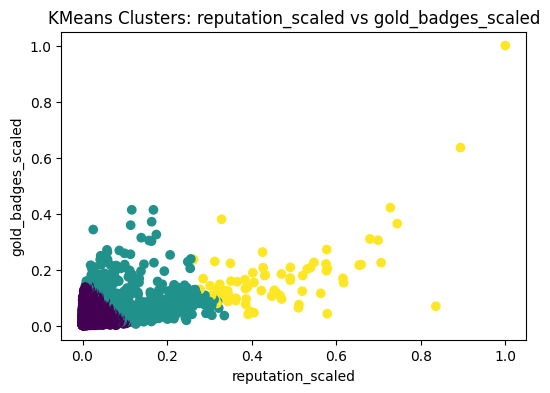

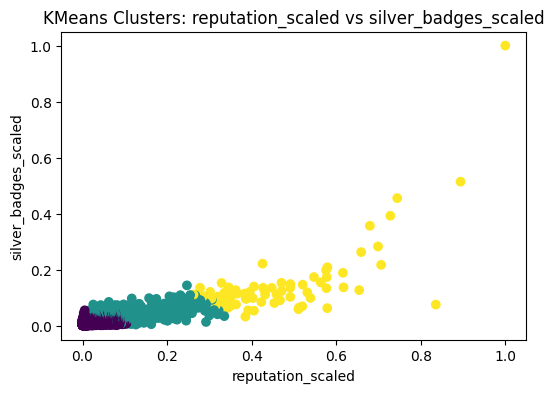

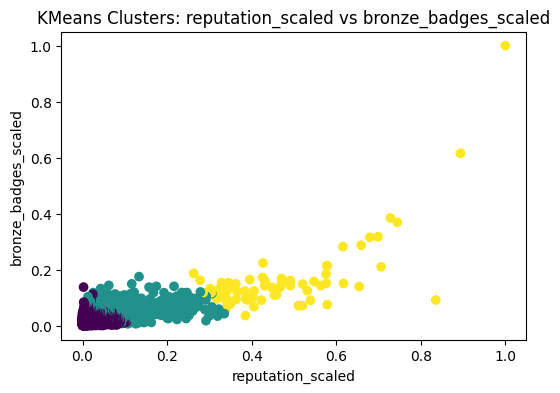

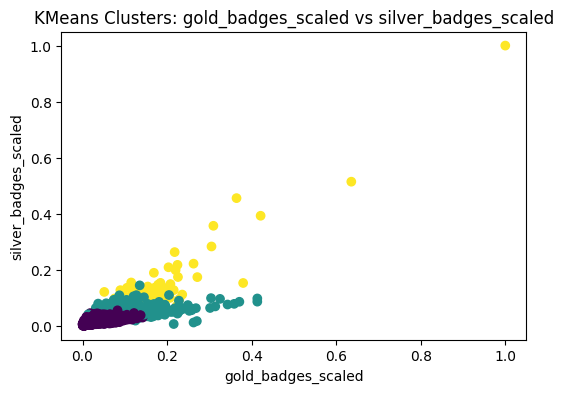

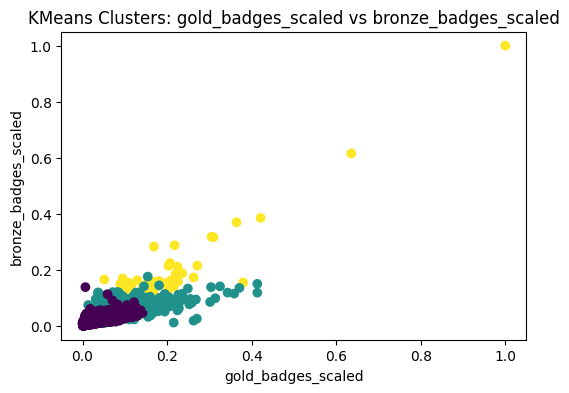

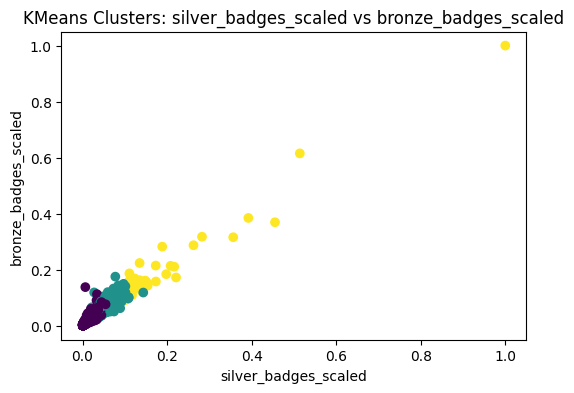

In [12]:
import itertools

features = so_scaled_features.columns
cluster_labels = kmeans_results['cluster']

for x, y in itertools.combinations(features, 2):
    plt.figure(figsize=(6,4))
    plt.scatter(
        so_scaled_features[x],
        so_scaled_features[y],
        c=cluster_labels
    )
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"KMeans Clusters: {x} vs {y}")
    plt.show()


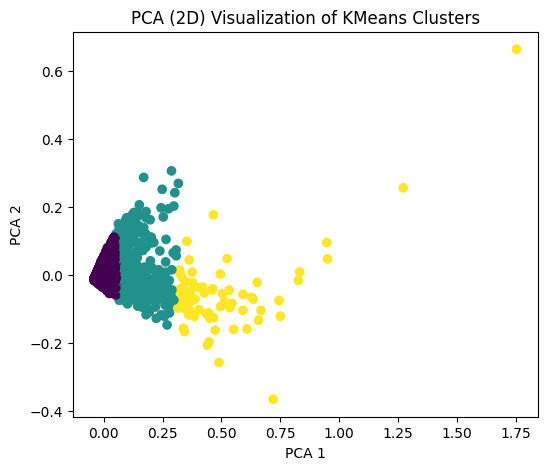

Explained Variance Ratio: [0.82427188 0.14886239]


In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(so_scaled_features)

plt.figure(figsize=(6,5))
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=cluster_labels)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA (2D) Visualization of KMeans Clusters")
plt.show()

print("Explained Variance Ratio:", pca.explained_variance_ratio_)


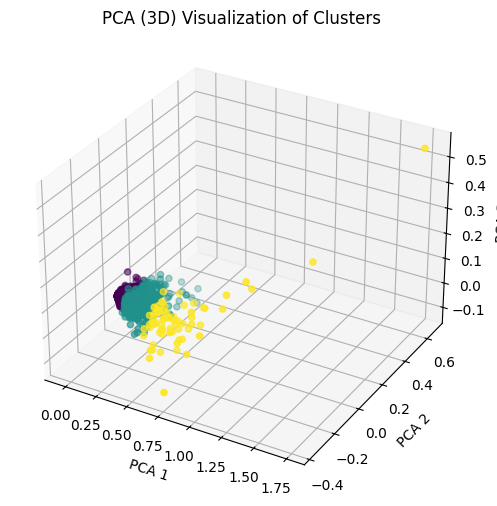

In [14]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
pca_3d = pca3.fit_transform(so_scaled_features)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    pca_3d[:,0],
    pca_3d[:,1],
    pca_3d[:,2],
    c=cluster_labels
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("PCA (3D) Visualization of Clusters")
plt.show()


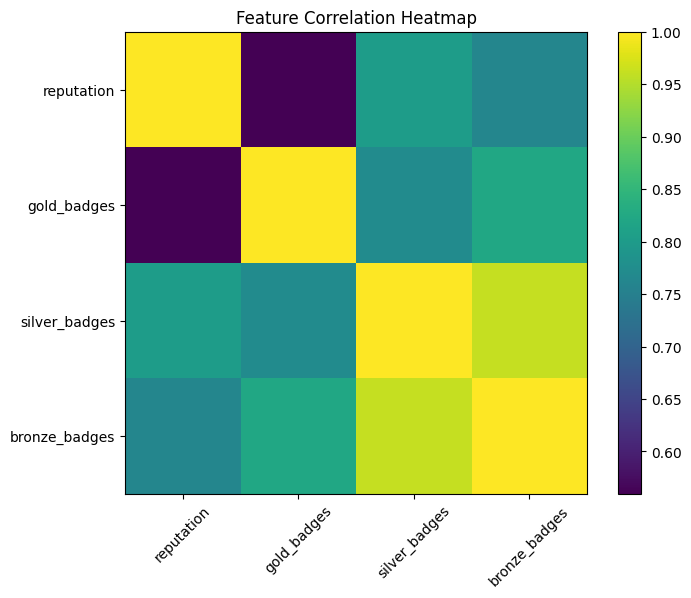

In [15]:
corr = df[so_features].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Feature Correlation Heatmap")
plt.show()


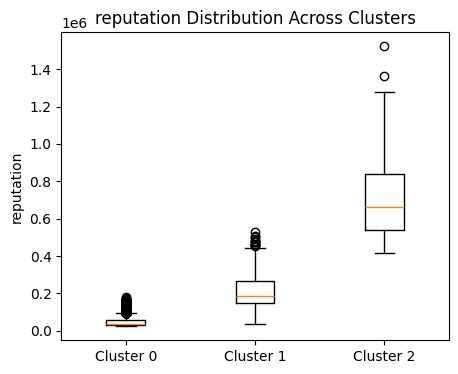

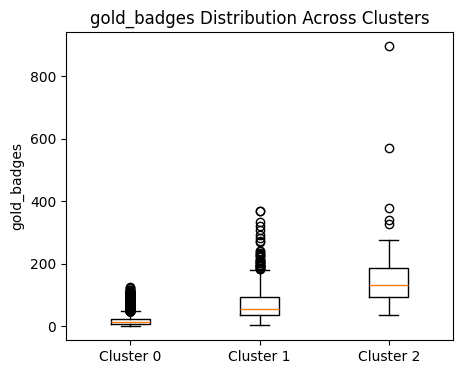

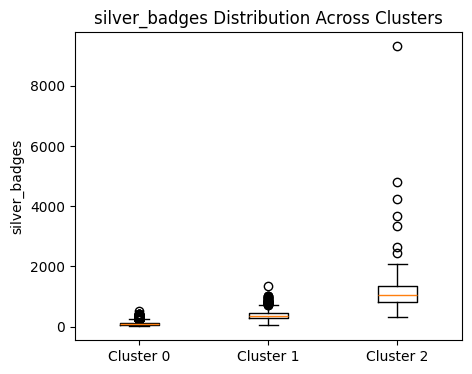

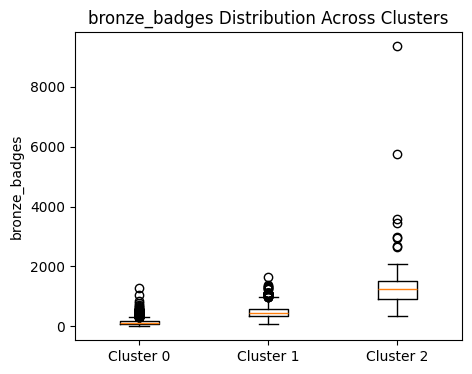

In [16]:
for col in so_features:
    plt.figure(figsize=(5,4))
    data = []
    for c in sorted(kmeans_results['cluster'].unique()):
        data.append(df[col][kmeans_results['cluster'] == c])
    
    plt.boxplot(data, labels=[f"Cluster {c}" for c in sorted(kmeans_results['cluster'].unique())])
    plt.title(f"{col} Distribution Across Clusters")
    plt.ylabel(col)
    plt.show()


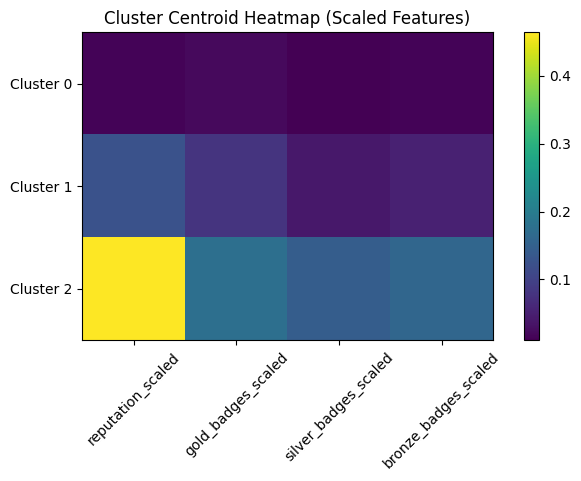

In [17]:
centroids = pd.DataFrame(
    kmeans_model.cluster_centers_,
    columns=so_scaled_features.columns
)

plt.figure(figsize=(8,4))
plt.imshow(centroids)
plt.colorbar()
plt.xticks(range(len(centroids.columns)), centroids.columns, rotation=45)
plt.yticks(range(len(centroids)), [f"Cluster {i}" for i in range(len(centroids))])
plt.title("Cluster Centroid Heatmap (Scaled Features)")
plt.show()


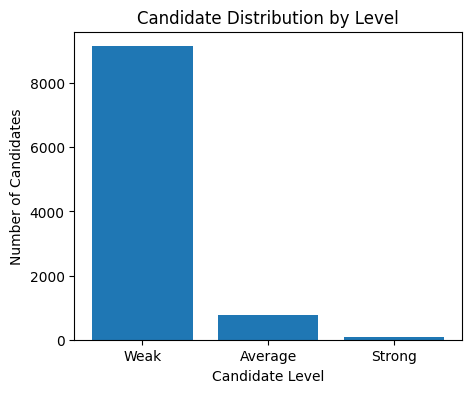

In [18]:
cluster_counts = kmeans_results['candidate_level'].value_counts()

plt.figure(figsize=(5,4))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.title("Candidate Distribution by Level")
plt.ylabel("Number of Candidates")
plt.xlabel("Candidate Level")
plt.show()


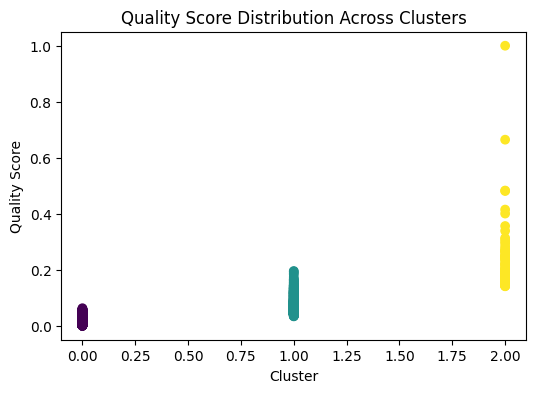

In [19]:
plt.figure(figsize=(6,4))
plt.scatter(
    kmeans_results['cluster'],
    kmeans_results['quality_score'],
    c=kmeans_results['cluster']
)
plt.xlabel("Cluster")
plt.ylabel("Quality Score")
plt.title("Quality Score Distribution Across Clusters")
plt.show()


Randoom forest


In [20]:
"""

print("RANDOM FOREST - SUPERVISED CLASSIFICATION")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Random Forest for classification again to comapre with kmeans results
rf_model_unlabelled= RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model_unlabelled.fit(so_scaled_features)
rf_clusters = rf_model_unlabelled.predict(so_scaled_features)
rf_proba = rf_model_unlabelled.predict_proba(so_scaled_features)  # Get probability for each class

# Create results dataframe
rf_results = pd.DataFrame({
    'cluster': rf_clusters,
    'quality_score': so_scaled_features.mean(axis=1),
    'confidence': rf_proba.max(axis=1)  # Maximum probability across classes
})

# Label clusters using same mapping as K-means
rf_results['candidate_level'] = rf_results['cluster'].map(cluster_to_label)

print("\nRandom Forest Classification Results:")
print(f"Cluster Distribution:\n{rf_results['candidate_level'].value_counts().sort_index()}")
print(f"\nCluster Profiles:")
for level in ['Weak', 'Average', 'Strong']:
    subset = rf_results[rf_results['candidate_level'] == level]
    print(f"{level:10} - Count: {len(subset):5} | Avg Quality Score: {subset['quality_score'].mean():.4f} | Avg Confidence: {subset['confidence'].mean():.4f}")


print("TOP 20 CANDIDATES")

rf_concatenated = pd.concat([so_primary, so_scaled_features, rf_results], axis=1)
#rf_display_cols = ['user_id', 'display_name', 'quality_score','cluster', 'candidate_level']
print(rf_concatenated.head(20).to_string(index=False))
"""


'\n\nprint("RANDOM FOREST - SUPERVISED CLASSIFICATION")\n\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import cross_val_score\n\n# Random Forest for classification again to comapre with kmeans results\nrf_model_unlabelled= RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)\nrf_model_unlabelled.fit(so_scaled_features)\nrf_clusters = rf_model_unlabelled.predict(so_scaled_features)\nrf_proba = rf_model_unlabelled.predict_proba(so_scaled_features)  # Get probability for each class\n\n# Create results dataframe\nrf_results = pd.DataFrame({\n    \'cluster\': rf_clusters,\n    \'quality_score\': so_scaled_features.mean(axis=1),\n    \'confidence\': rf_proba.max(axis=1)  # Maximum probability across classes\n})\n\n# Label clusters using same mapping as K-means\nrf_results[\'candidate_level\'] = rf_results[\'cluster\'].map(cluster_to_label)\n\nprint("\nRandom Forest Classification Results:")\nprint(f"Cluster Distribution:\n{r

Now the kmeans model has classified the candidate level as Strong, avg and weak having a particulalar quality score and cluster.
Next the labelled_final file will be used in superviseed algo and the model will be used to classify new data

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Features
X = so_scaled_features.copy()

# Target
y = kmeans_results['candidate_level']

# Encode labels: Weak / Average / Strong → 0 / 1 / 2
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(label_encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)




['Average' 'Strong' 'Weak']


RandomForestClassifier(n_estimators=200, random_state=42)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9936

Classification Report:
              precision    recall  f1-score   support

     Average       0.97      0.94      0.96       194
      Strong       0.90      1.00      0.95        19
        Weak       1.00      1.00      1.00      2287

    accuracy                           0.99      2500
   macro avg       0.96      0.98      0.97      2500
weighted avg       0.99      0.99      0.99      2500


Confusion Matrix:
[[ 183    2    9]
 [   0   19    0]
 [   5    0 2282]]


In [23]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9936


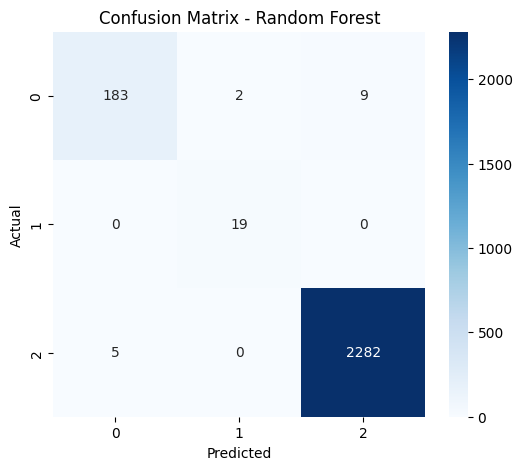

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [25]:
from sklearn.metrics import balanced_accuracy_score

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)


Balanced Accuracy: 0.9803708996163886


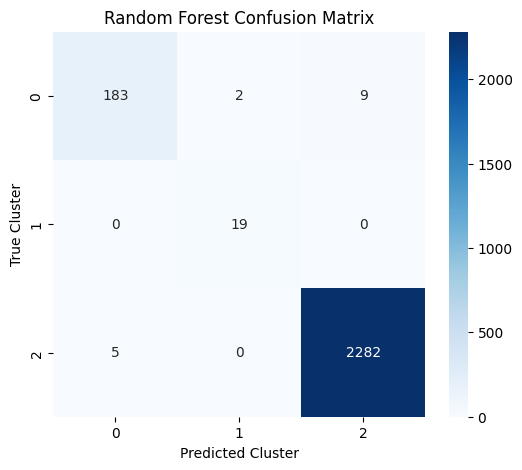

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict
y_pred = rf_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Cluster")
plt.title("Random Forest Confusion Matrix")
plt.show()


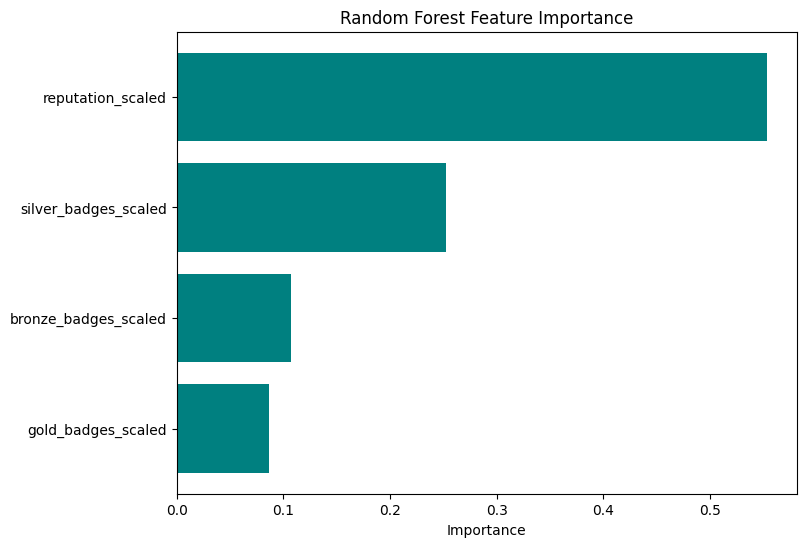

In [27]:
import pandas as pd

# Feature importance
feature_importance = pd.DataFrame({
    "feature": features,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=True)

# Horizontal bar plot
plt.figure(figsize=(8,6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='teal')
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()


LR for for kmeans results as psuedu input.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Logistic Regression
lr_model = LogisticRegression(
    #multi_class='multinomial',  # for 3 classes
    solver='lbfgs',             # recommended for multinomial
    max_iter=1000,
    random_state=42
)

# Train
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy: 0.9496

Classification Report:
              precision    recall  f1-score   support

     Average       0.84      0.43      0.57       194
      Strong       1.00      0.16      0.27        19
        Weak       0.95      1.00      0.98      2287

    accuracy                           0.95      2500
   macro avg       0.93      0.53      0.61      2500
weighted avg       0.95      0.95      0.94      2500


Confusion Matrix:
[[  84    0  110]
 [  16    3    0]
 [   0    0 2287]]


# COMPREHENSIVE MODEL COMPARISON: UNSUPERVISED & SUPERVISED LEARNING

In [29]:
# ============================================================================
# UNSUPERVISED LEARNING MODELS COMPARISON
# ============================================================================

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("="*80)
print("UNSUPERVISED LEARNING MODELS")
print("="*80)

unsupervised_models = {}
unsupervised_results = {}

# 1. K-MEANS (Already Have)
print("\n1. K-MEANS CLUSTERING")
unsupervised_models['KMeans'] = kmeans_model
kmeans_pred = kmeans_model.predict(so_scaled_features)
unsupervised_results['KMeans'] = kmeans_pred

# 2. GAUSSIAN MIXTURE MODEL (GMM)
print("\n2. GAUSSIAN MIXTURE MODEL (GMM)")
gmm_model = GaussianMixture(n_components=3, random_state=42)
gmm_pred = gmm_model.fit_predict(so_scaled_features)
unsupervised_models['GMM'] = gmm_model
unsupervised_results['GMM'] = gmm_pred

# 3. HIERARCHICAL CLUSTERING (Ward Linkage)
print("\n3. HIERARCHICAL CLUSTERING (Ward Linkage)")
hierarchical_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
hier_pred = hierarchical_model.fit_predict(so_scaled_features)
unsupervised_models['Hierarchical'] = hierarchical_model
unsupervised_results['Hierarchical'] = hier_pred

# 4. DBSCAN
print("\n4. DBSCAN Clustering")
dbscan_model = DBSCAN(eps=0.3, min_samples=5)
dbscan_pred = dbscan_model.fit_predict(so_scaled_features)
unsupervised_models['DBSCAN'] = dbscan_model
unsupervised_results['DBSCAN'] = dbscan_pred

# 5. SPECTRAL CLUSTERING
print("\n5. SPECTRAL CLUSTERING")
spectral_model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
spectral_pred = spectral_model.fit_predict(so_scaled_features)
unsupervised_models['Spectral'] = spectral_model
unsupervised_results['Spectral'] = spectral_pred

print("\n" + "="*80)
print("Unsupervised Models Created Successfully!")
print("="*80)

UNSUPERVISED LEARNING MODELS

1. K-MEANS CLUSTERING

2. GAUSSIAN MIXTURE MODEL (GMM)

3. HIERARCHICAL CLUSTERING (Ward Linkage)

4. DBSCAN Clustering

5. SPECTRAL CLUSTERING

Unsupervised Models Created Successfully!


In [30]:
# ============================================================================
# UNSUPERVISED CLUSTERING EVALUATION METRICS
# ============================================================================

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("UNSUPERVISED MODELS EVALUATION METRICS")
print("="*80)

unsupervised_eval = {}

for model_name, predictions in unsupervised_results.items():
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    
    # Skip DBSCAN if noise points exist
    if model_name == 'DBSCAN':
        n_clusters = len(set(predictions)) - (1 if -1 in predictions else 0)
        n_noise = list(predictions).count(-1)
        print(f"Number of Clusters Found: {n_clusters}")
        print(f"Noise Points: {n_noise}")
        
        if n_noise > 0 or n_clusters < 2:
            print("⚠ DBSCAN: Insufficient clusters for evaluation metrics")
            unsupervised_eval[model_name] = {
                'silhouette': np.nan,
                'davies_bouldin': np.nan,
                'calinski_harabasz': np.nan,
                'n_clusters': n_clusters
            }
            continue
    
    # Silhouette Score
    sil_score = silhouette_score(so_scaled_features, predictions)
    
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(so_scaled_features, predictions)
    
    # Calinski-Harabasz Score
    ch_score = calinski_harabasz_score(so_scaled_features, predictions)
    
    print(f"Silhouette Score: {sil_score:.4f} (Range: [-1, 1], Higher is Better)")
    print(f"Davies-Bouldin Index: {db_index:.4f} (Lower is Better)")
    print(f"Calinski-Harabasz Score: {ch_score:.4f} (Higher is Better)")
    
    unsupervised_eval[model_name] = {
        'silhouette': sil_score,
        'davies_bouldin': db_index,
        'calinski_harabasz': ch_score,
        'n_clusters': len(set(predictions)) - (1 if -1 in predictions else 0)
    }

# Create evaluation DataFrame
unsupervised_eval_df = pd.DataFrame(unsupervised_eval).T
print("\n" + "="*80)
print("UNSUPERVISED MODELS COMPARISON TABLE")
print("="*80)
print(unsupervised_eval_df.round(4))


UNSUPERVISED MODELS EVALUATION METRICS

KMEANS
------------------------------------------------------------
Silhouette Score: 0.7227 (Range: [-1, 1], Higher is Better)
Davies-Bouldin Index: 0.7507 (Lower is Better)
Calinski-Harabasz Score: 8121.5603 (Higher is Better)

GMM
------------------------------------------------------------
Silhouette Score: 0.4332 (Range: [-1, 1], Higher is Better)
Davies-Bouldin Index: 1.0609 (Lower is Better)
Calinski-Harabasz Score: 4884.1233 (Higher is Better)

HIERARCHICAL
------------------------------------------------------------
Silhouette Score: 0.7291 (Range: [-1, 1], Higher is Better)
Davies-Bouldin Index: 0.7629 (Lower is Better)
Calinski-Harabasz Score: 7958.1522 (Higher is Better)

DBSCAN
------------------------------------------------------------
Number of Clusters Found: 1
Noise Points: 2
⚠ DBSCAN: Insufficient clusters for evaluation metrics

SPECTRAL
------------------------------------------------------------
Silhouette Score: 0.3140 (Ra

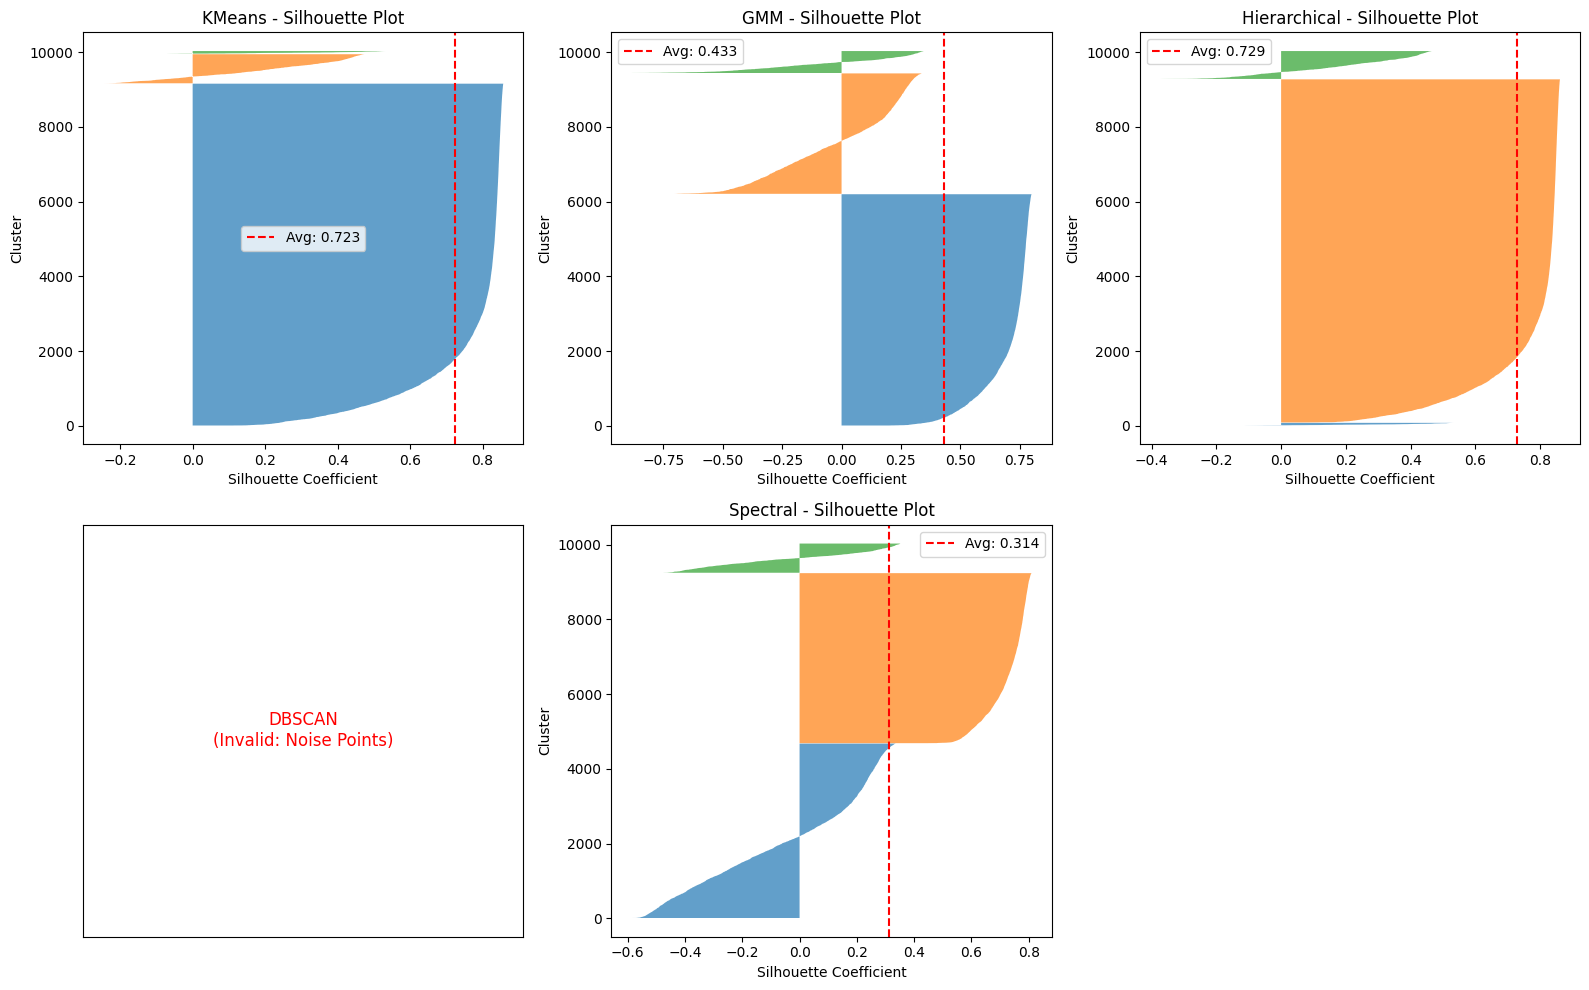

✓ Silhouette comparison visualization saved


In [31]:
# ============================================================================
# UNSUPERVISED MODELS VISUALIZATION - SILHOUETTE COMPARISON
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

model_names = ['KMeans', 'GMM', 'Hierarchical', 'DBSCAN', 'Spectral']

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    predictions = unsupervised_results[model_name]
    
    # Skip DBSCAN if noise points
    if model_name == 'DBSCAN' and -1 in predictions:
        ax.text(0.5, 0.5, f'{model_name}\n(Invalid: Noise Points)', 
                ha='center', va='center', fontsize=12, color='red')
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    
    # Silhouette samples
    if model_name != 'DBSCAN' or -1 not in predictions:
        sil_samples = silhouette_samples(so_scaled_features, predictions)
        
        y_lower = 10
        for i in range(len(set(predictions))):
            cluster_sil = sil_samples[predictions == i]
            cluster_sil.sort()
            
            size_cluster = cluster_sil.shape[0]
            y_upper = y_lower + size_cluster
            
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil, alpha=0.7)
            y_lower = y_upper + 10
        
        ax.set_xlabel("Silhouette Coefficient")
        ax.set_ylabel("Cluster")
        ax.set_title(f"{model_name} - Silhouette Plot")
        ax.axvline(x=unsupervised_eval[model_name]['silhouette'], color="red", linestyle="--", 
                   label=f"Avg: {unsupervised_eval[model_name]['silhouette']:.3f}")
        ax.legend()

# Hide unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/unsupervised_silhouette_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Silhouette comparison visualization saved")

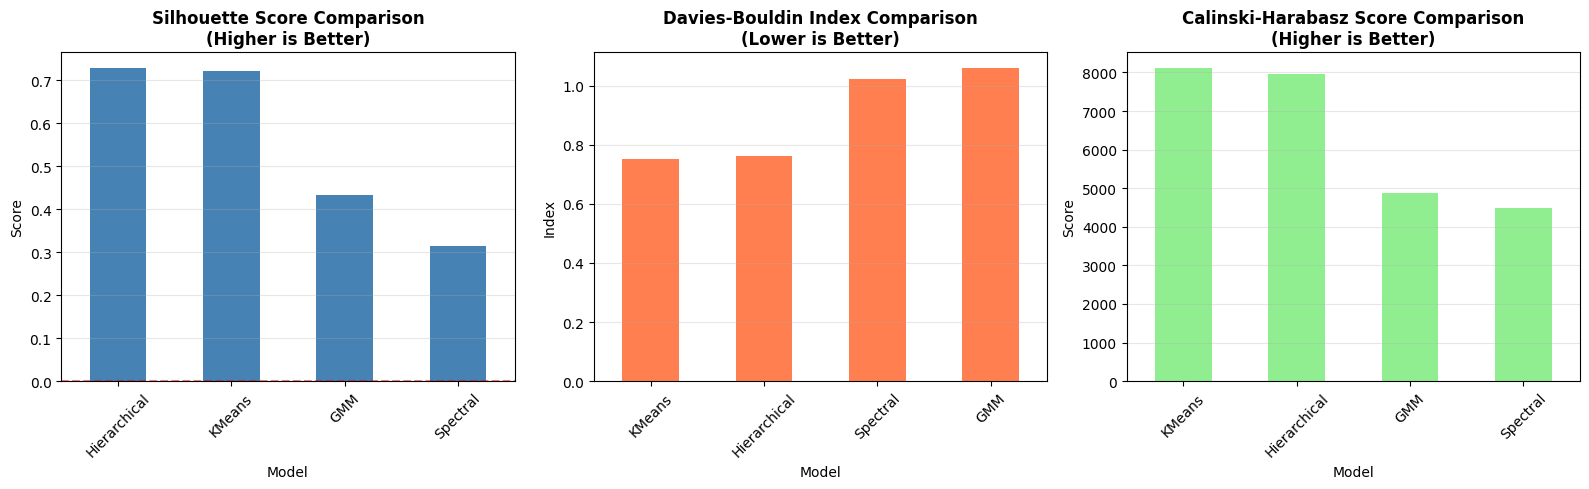

✓ Metrics comparison visualization saved


In [32]:
# ============================================================================
# UNSUPERVISED MODELS COMPARISON - BAR CHARTS
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Filter out DBSCAN if invalid
eval_df_clean = unsupervised_eval_df.dropna()

# 1. Silhouette Score Comparison
ax1 = axes[0]
eval_df_clean['silhouette'].sort_values(ascending=False).plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Silhouette Score Comparison\n(Higher is Better)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_xlabel('Model')
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Davies-Bouldin Index Comparison
ax2 = axes[1]
eval_df_clean['davies_bouldin'].sort_values(ascending=True).plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Davies-Bouldin Index Comparison\n(Lower is Better)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Index')
ax2.set_xlabel('Model')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Calinski-Harabasz Score Comparison
ax3 = axes[2]
eval_df_clean['calinski_harabasz'].sort_values(ascending=False).plot(kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('Calinski-Harabasz Score Comparison\n(Higher is Better)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xlabel('Model')
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/unsupervised_metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Metrics comparison visualization saved")

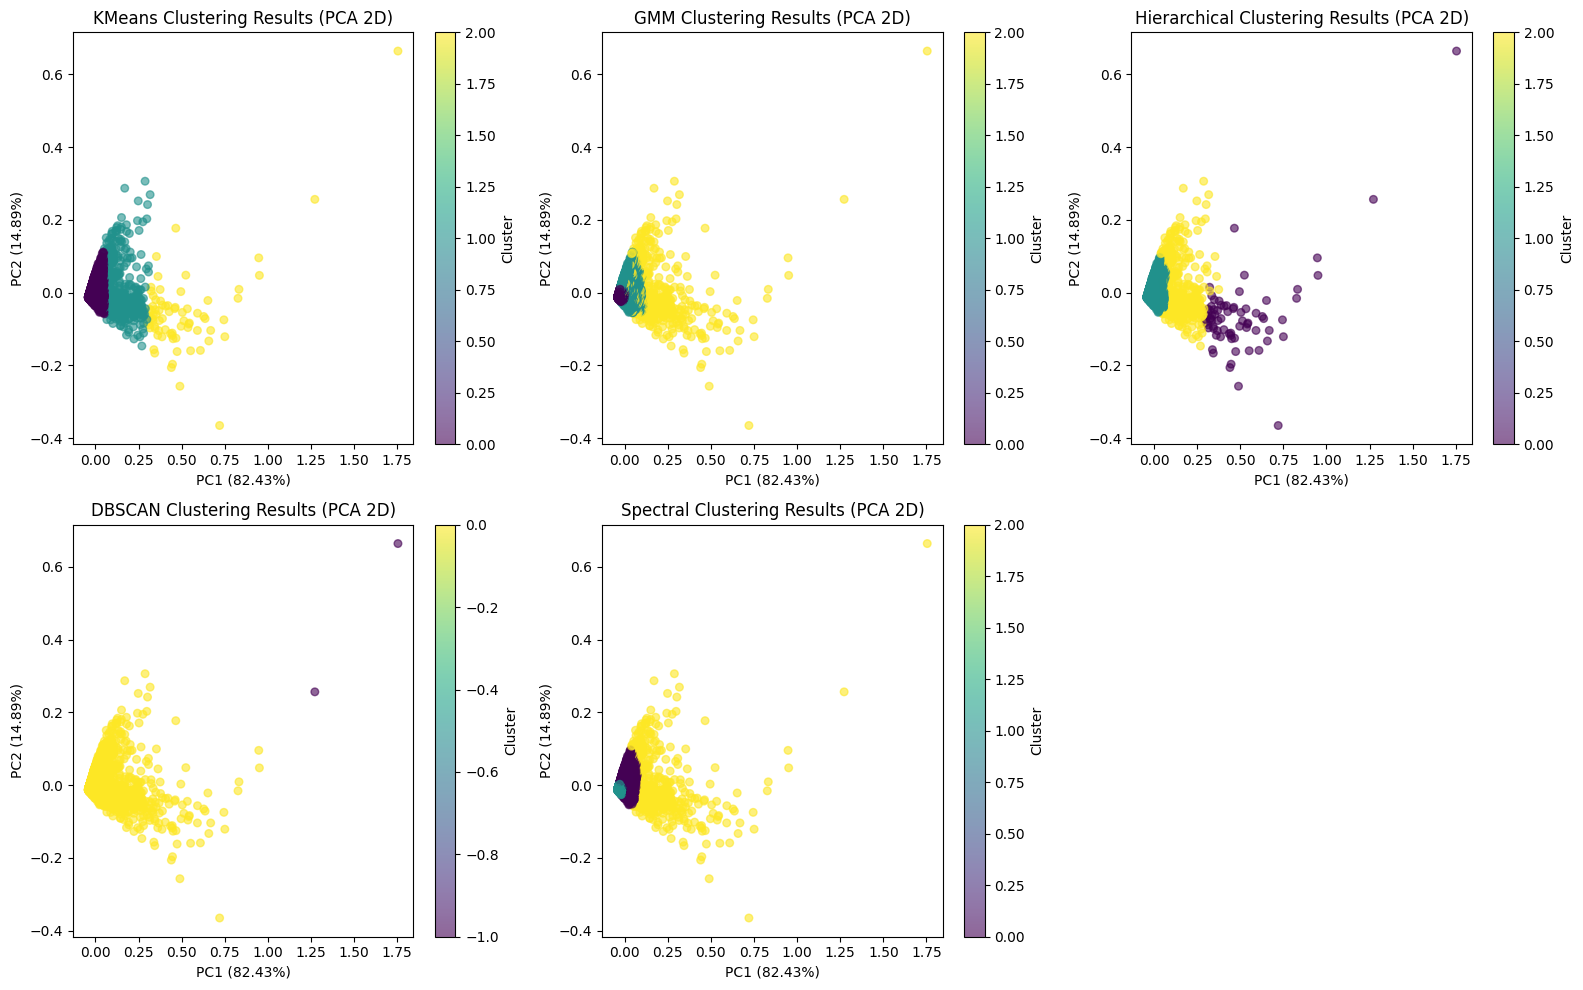

✓ PCA visualization saved (Variance Explained: 97.31%)


In [33]:
# ============================================================================
# UNSUPERVISED MODELS 2D PCA VISUALIZATION COMPARISON
# ============================================================================

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(so_scaled_features)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

model_names = ['KMeans', 'GMM', 'Hierarchical', 'DBSCAN', 'Spectral']

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    predictions = unsupervised_results[model_name]
    
    scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], c=predictions, cmap='viridis', s=30, alpha=0.6)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax.set_title(f'{model_name} Clustering Results (PCA 2D)')
    plt.colorbar(scatter, ax=ax, label='Cluster')

axes[-1].axis('off')

plt.tight_layout()
plt.savefig("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/unsupervised_pca_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ PCA visualization saved (Variance Explained: {pca.explained_variance_ratio_.sum():.2%})")

# SUPERVISED LEARNING MODELS COMPARISON

In [34]:
# ============================================================================
# SUPERVISED LEARNING MODELS - TRAINING AND EVALUATION
# ============================================================================

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             balanced_accuracy_score, cohen_kappa_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("SUPERVISED LEARNING MODELS - SETUP")
print("="*80)

# Prepare data with labels from K-Means
X = so_scaled_features.copy()
y = kmeans_results['candidate_level']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Classes: {label_encoder.classes_}")
print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{pd.Series(y_encoded, index=y_encoded).value_counts().sort_index()}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Dictionary to store all models
supervised_models = {}
supervised_results = {}

# ============================================================================
# 1. RANDOM FOREST
# ============================================================================
print("\n" + "="*80)
print("1. RANDOM FOREST CLASSIFIER")
print("="*80)

rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)

supervised_models['Random Forest'] = rf_model
supervised_results['Random Forest'] = {
    'y_pred': rf_pred,
    'y_proba': rf_proba,
    'model': rf_model
}

# ============================================================================
# 2. GRADIENT BOOSTING
# ============================================================================
print("\n" + "="*80)
print("2. GRADIENT BOOSTING CLASSIFIER")
print("="*80)

gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_proba = gb_model.predict_proba(X_test)

supervised_models['Gradient Boosting'] = gb_model
supervised_results['Gradient Boosting'] = {
    'y_pred': gb_pred,
    'y_proba': gb_proba,
    'model': gb_model
}

# ============================================================================
# 3. SUPPORT VECTOR MACHINE (SVM)
# ============================================================================
print("\n" + "="*80)
print("3. SUPPORT VECTOR MACHINE")
print("="*80)

svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_proba = svm_model.predict_proba(X_test)

supervised_models['SVM'] = svm_model
supervised_results['SVM'] = {
    'y_pred': svm_pred,
    'y_proba': svm_proba,
    'model': svm_model
}

# ============================================================================
# 4. LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*80)
print("4. LOGISTIC REGRESSION")
print("="*80)

lr_model = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial', random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)

supervised_models['Logistic Regression'] = lr_model
supervised_results['Logistic Regression'] = {
    'y_pred': lr_pred,
    'y_proba': lr_proba,
    'model': lr_model
}

# ============================================================================
# 5. K-NEAREST NEIGHBORS
# ============================================================================
print("\n" + "="*80)
print("5. K-NEAREST NEIGHBORS")
print("="*80)

knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_proba = knn_model.predict_proba(X_test)

supervised_models['KNN'] = knn_model
supervised_results['KNN'] = {
    'y_pred': knn_pred,
    'y_proba': knn_proba,
    'model': knn_model
}

# ============================================================================
# 6. NAIVE BAYES
# ============================================================================
print("\n" + "="*80)
print("6. GAUSSIAN NAIVE BAYES")
print("="*80)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_proba = nb_model.predict_proba(X_test)

supervised_models['Naive Bayes'] = nb_model
supervised_results['Naive Bayes'] = {
    'y_pred': nb_pred,
    'y_proba': nb_proba,
    'model': nb_model
}

# ============================================================================
# 7. DECISION TREE
# ============================================================================
print("\n" + "="*80)
print("7. DECISION TREE")
print("="*80)

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_proba = dt_model.predict_proba(X_test)

supervised_models['Decision Tree'] = dt_model
supervised_results['Decision Tree'] = {
    'y_pred': dt_pred,
    'y_proba': dt_proba,
    'model': dt_model
}

# ============================================================================
# 8. ADA BOOST
# ============================================================================
print("\n" + "="*80)
print("8. ADA BOOST CLASSIFIER")
print("="*80)

ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)
ada_pred = ada_model.predict(X_test)
ada_proba = ada_model.predict_proba(X_test)

supervised_models['AdaBoost'] = ada_model
supervised_results['AdaBoost'] = {
    'y_pred': ada_pred,
    'y_proba': ada_proba,
    'model': ada_model
}

print("\n" + "="*80)
print("All Supervised Models Trained Successfully!")
print("="*80)

SUPERVISED LEARNING MODELS - SETUP
Classes: ['Average' 'Strong' 'Weak']
Features shape: (10000, 4)
Target distribution:
0     778
1      75
2    9147
Name: count, dtype: int64

Train set size: 7500
Test set size: 2500

1. RANDOM FOREST CLASSIFIER

2. GRADIENT BOOSTING CLASSIFIER

3. SUPPORT VECTOR MACHINE

4. LOGISTIC REGRESSION

5. K-NEAREST NEIGHBORS

6. GAUSSIAN NAIVE BAYES

7. DECISION TREE

8. ADA BOOST CLASSIFIER

All Supervised Models Trained Successfully!


In [35]:
# ============================================================================
# SUPERVISED MODELS EVALUATION METRICS - COMPREHENSIVE
# ============================================================================

print("="*80)
print("SUPERVISED MODELS - COMPREHENSIVE EVALUATION METRICS")
print("="*80)

evaluation_metrics = {}

for model_name, results in supervised_results.items():
    y_pred = results['y_pred']
    y_proba = results['y_proba']
    
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    
    # 1. Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # 2. Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    # 3. Precision (weighted)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # 4. Recall (weighted)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # 5. F1-Score (weighted)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # 6. Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # 7. Macro F1
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # 8. Macro Precision
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    
    # 9. Macro Recall
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"Accuracy:              {accuracy:.4f}")
    print(f"Balanced Accuracy:     {balanced_acc:.4f}")
    print(f"Precision (weighted):  {precision:.4f}")
    print(f"Recall (weighted):     {recall:.4f}")
    print(f"F1-Score (weighted):   {f1:.4f}")
    print(f"Cohen's Kappa:         {kappa:.4f}")
    print(f"F1-Score (macro):      {f1_macro:.4f}")
    
    evaluation_metrics[model_name] = {
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_acc,
        'Precision (weighted)': precision,
        'Recall (weighted)': recall,
        'F1-Score (weighted)': f1,
        'Cohen\'s Kappa': kappa,
        'F1-Score (macro)': f1_macro,
        'Precision (macro)': precision_macro,
        'Recall (macro)': recall_macro
    }

# Create comprehensive evaluation DataFrame
eval_metrics_df = pd.DataFrame(evaluation_metrics).T

print("\n" + "="*80)
print("SUPERVISED MODELS COMPARISON TABLE - ALL METRICS")
print("="*80)
print(eval_metrics_df.round(4))

SUPERVISED MODELS - COMPREHENSIVE EVALUATION METRICS

RANDOM FOREST
------------------------------------------------------------
Accuracy:              0.9936
Balanced Accuracy:     0.9804
Precision (weighted):  0.9936
Recall (weighted):     0.9936
F1-Score (weighted):   0.9936
Cohen's Kappa:         0.9589
F1-Score (macro):      0.9684

GRADIENT BOOSTING
------------------------------------------------------------
Accuracy:              0.9932
Balanced Accuracy:     0.9628
Precision (weighted):  0.9932
Recall (weighted):     0.9932
F1-Score (weighted):   0.9932
Cohen's Kappa:         0.9563
F1-Score (macro):      0.9585

SVM
------------------------------------------------------------
Accuracy:              0.9960
Balanced Accuracy:     0.9844
Precision (weighted):  0.9960
Recall (weighted):     0.9960
F1-Score (weighted):   0.9960
Cohen's Kappa:         0.9742
F1-Score (macro):      0.9820

LOGISTIC REGRESSION
------------------------------------------------------------
Accuracy:    

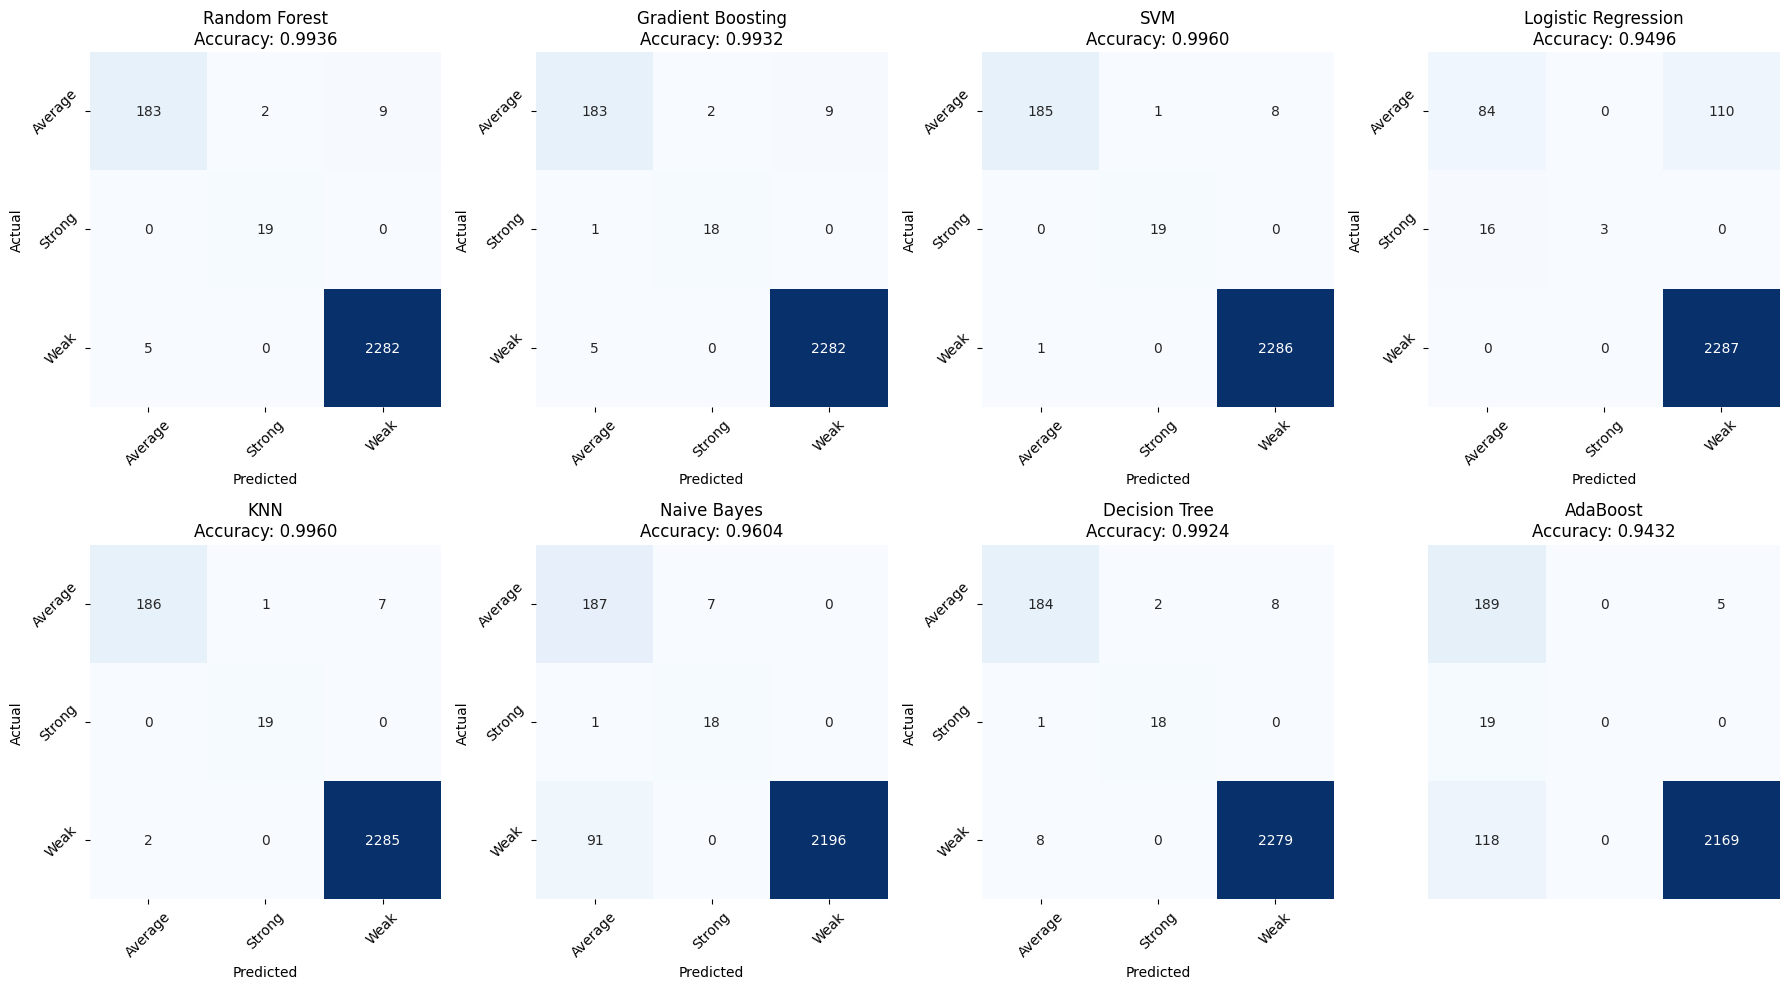

✓ Confusion matrices visualization saved


In [36]:
# ============================================================================
# SUPERVISED MODELS - CONFUSION MATRICES VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, (model_name, results) in enumerate(supervised_results.items()):
    ax = axes[idx]
    y_pred = results['y_pred']
    
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name}\nAccuracy: {accuracy_score(y_test, y_pred):.4f}')
    ax.set_xticklabels(label_encoder.classes_, rotation=45)
    ax.set_yticklabels(label_encoder.classes_, rotation=45)

# Hide the empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/supervised_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices visualization saved")

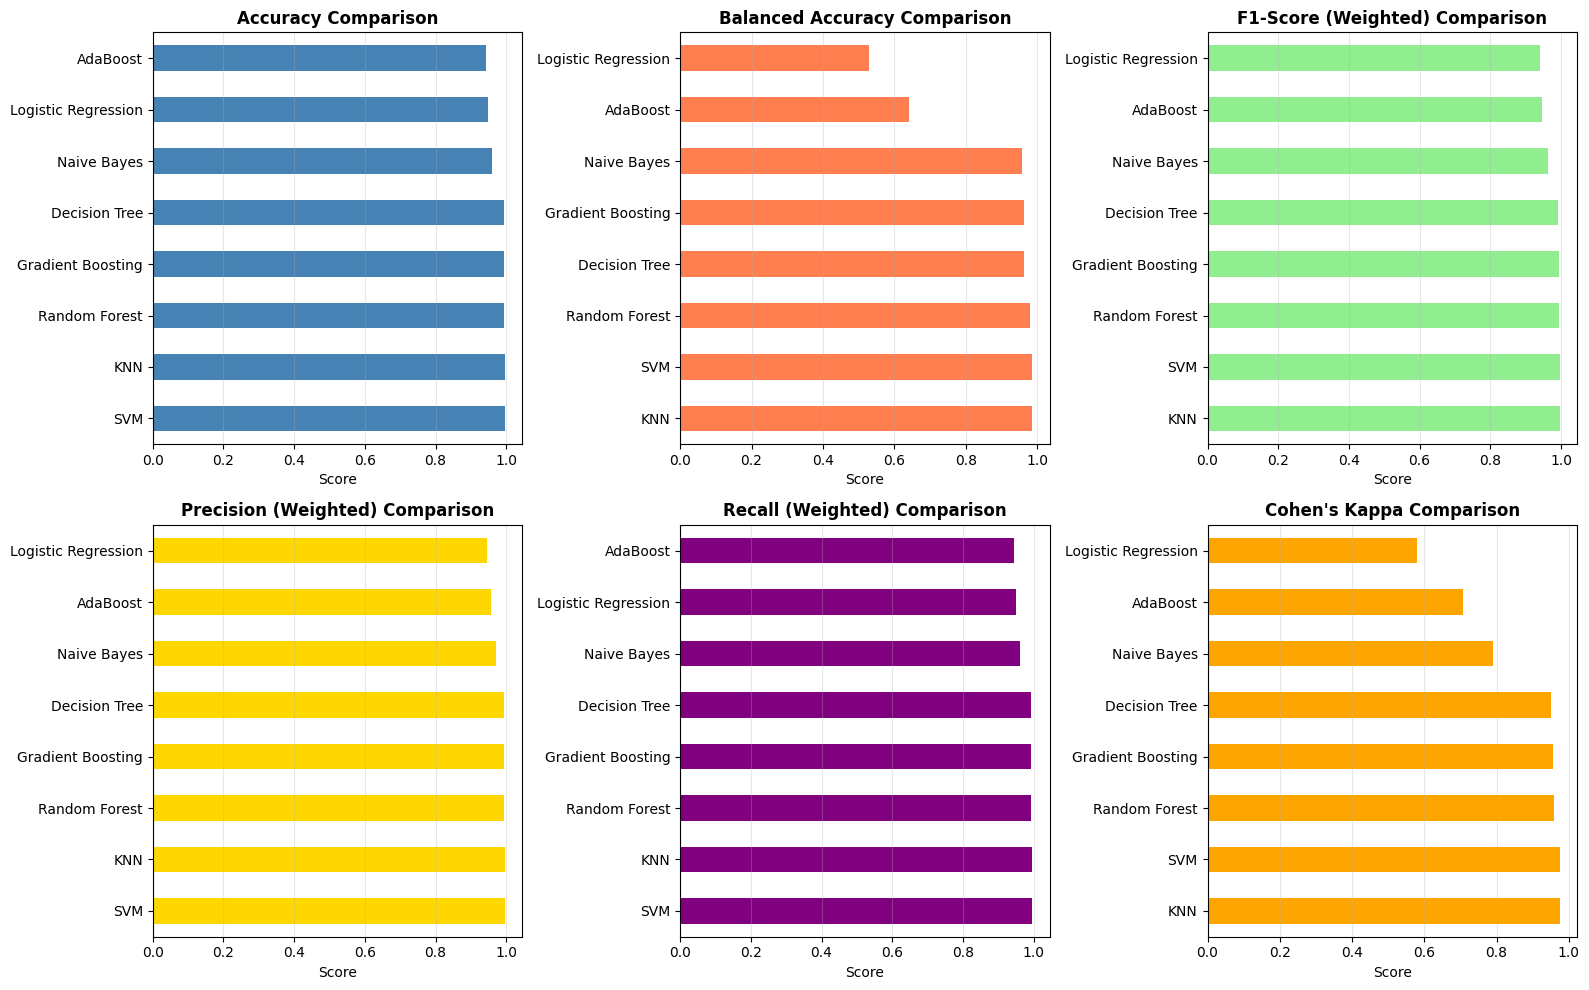

✓ Metrics comparison visualization saved


In [37]:
# ============================================================================
# SUPERVISED MODELS - METRICS COMPARISON VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
eval_metrics_df['Accuracy'].sort_values(ascending=False).plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_title('Accuracy Comparison', fontweight='bold')
ax1.set_xlabel('Score')
ax1.grid(axis='x', alpha=0.3)

# 2. Balanced Accuracy Comparison
ax2 = axes[0, 1]
eval_metrics_df['Balanced Accuracy'].sort_values(ascending=False).plot(kind='barh', ax=ax2, color='coral')
ax2.set_title('Balanced Accuracy Comparison', fontweight='bold')
ax2.set_xlabel('Score')
ax2.grid(axis='x', alpha=0.3)

# 3. F1-Score Comparison
ax3 = axes[0, 2]
eval_metrics_df['F1-Score (weighted)'].sort_values(ascending=False).plot(kind='barh', ax=ax3, color='lightgreen')
ax3.set_title('F1-Score (Weighted) Comparison', fontweight='bold')
ax3.set_xlabel('Score')
ax3.grid(axis='x', alpha=0.3)

# 4. Precision Comparison
ax4 = axes[1, 0]
eval_metrics_df['Precision (weighted)'].sort_values(ascending=False).plot(kind='barh', ax=ax4, color='gold')
ax4.set_title('Precision (Weighted) Comparison', fontweight='bold')
ax4.set_xlabel('Score')
ax4.grid(axis='x', alpha=0.3)

# 5. Recall Comparison
ax5 = axes[1, 1]
eval_metrics_df['Recall (weighted)'].sort_values(ascending=False).plot(kind='barh', ax=ax5, color='purple')
ax5.set_title('Recall (Weighted) Comparison', fontweight='bold')
ax5.set_xlabel('Score')
ax5.grid(axis='x', alpha=0.3)

# 6. Cohen's Kappa Comparison
ax6 = axes[1, 2]
eval_metrics_df['Cohen\'s Kappa'].sort_values(ascending=False).plot(kind='barh', ax=ax6, color='orange')
ax6.set_title('Cohen\'s Kappa Comparison', fontweight='bold')
ax6.set_xlabel('Score')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/supervised_metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Metrics comparison visualization saved")

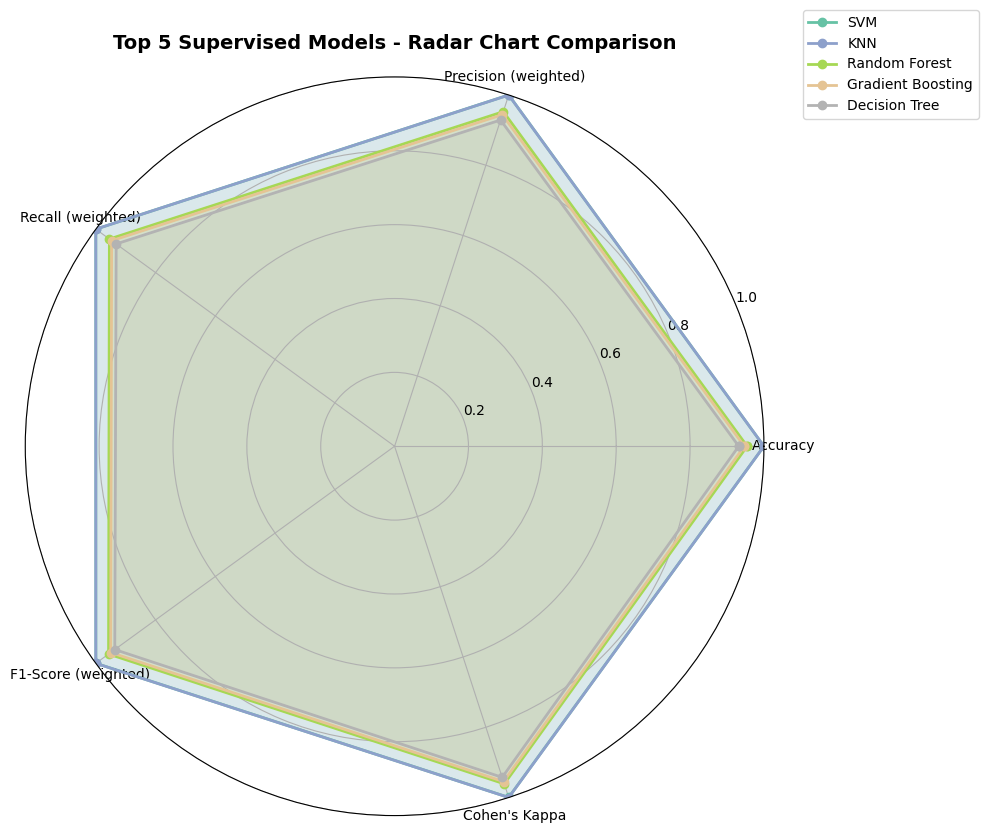

✓ Radar chart comparison visualization saved


In [38]:
# ============================================================================
# RADAR CHART COMPARISON - SUPERVISED MODELS
# ============================================================================

import numpy as np
from math import pi

# Normalize metrics for radar chart (0-1 scale)
metrics_for_radar = ['Accuracy', 'Precision (weighted)', 'Recall (weighted)', 
                     'F1-Score (weighted)', 'Cohen\'s Kappa']

radar_data = eval_metrics_df[metrics_for_radar].copy()

# Normalize to 0-1 range for better visualization
for col in metrics_for_radar:
    min_val = radar_data[col].min()
    max_val = radar_data[col].max()
    radar_data[col] = (radar_data[col] - min_val) / (max_val - min_val)

# Number of variables
N = len(metrics_for_radar)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Select top models for clarity
top_models = eval_metrics_df['Accuracy'].nlargest(5).index.tolist()

colors = plt.cm.Set2(np.linspace(0, 1, len(top_models)))

for idx, model_name in enumerate(top_models):
    values = radar_data.loc[model_name].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar, size=10)
ax.set_ylim(0, 1)
ax.set_title('Top 5 Supervised Models - Radar Chart Comparison', size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/supervised_radar_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Radar chart comparison visualization saved")

In [39]:
# ============================================================================
# SUPERVISED MODELS - DETAILED CLASSIFICATION REPORTS
# ============================================================================

print("="*80)
print("SUPERVISED MODELS - DETAILED CLASSIFICATION REPORTS")
print("="*80)

for model_name, results in supervised_results.items():
    y_pred = results['y_pred']
    
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("\n")

SUPERVISED MODELS - DETAILED CLASSIFICATION REPORTS

RANDOM FOREST
------------------------------------------------------------
              precision    recall  f1-score   support

     Average       0.97      0.94      0.96       194
      Strong       0.90      1.00      0.95        19
        Weak       1.00      1.00      1.00      2287

    accuracy                           0.99      2500
   macro avg       0.96      0.98      0.97      2500
weighted avg       0.99      0.99      0.99      2500




GRADIENT BOOSTING
------------------------------------------------------------
              precision    recall  f1-score   support

     Average       0.97      0.94      0.96       194
      Strong       0.90      0.95      0.92        19
        Weak       1.00      1.00      1.00      2287

    accuracy                           0.99      2500
   macro avg       0.95      0.96      0.96      2500
weighted avg       0.99      0.99      0.99      2500




SVM
---------------------

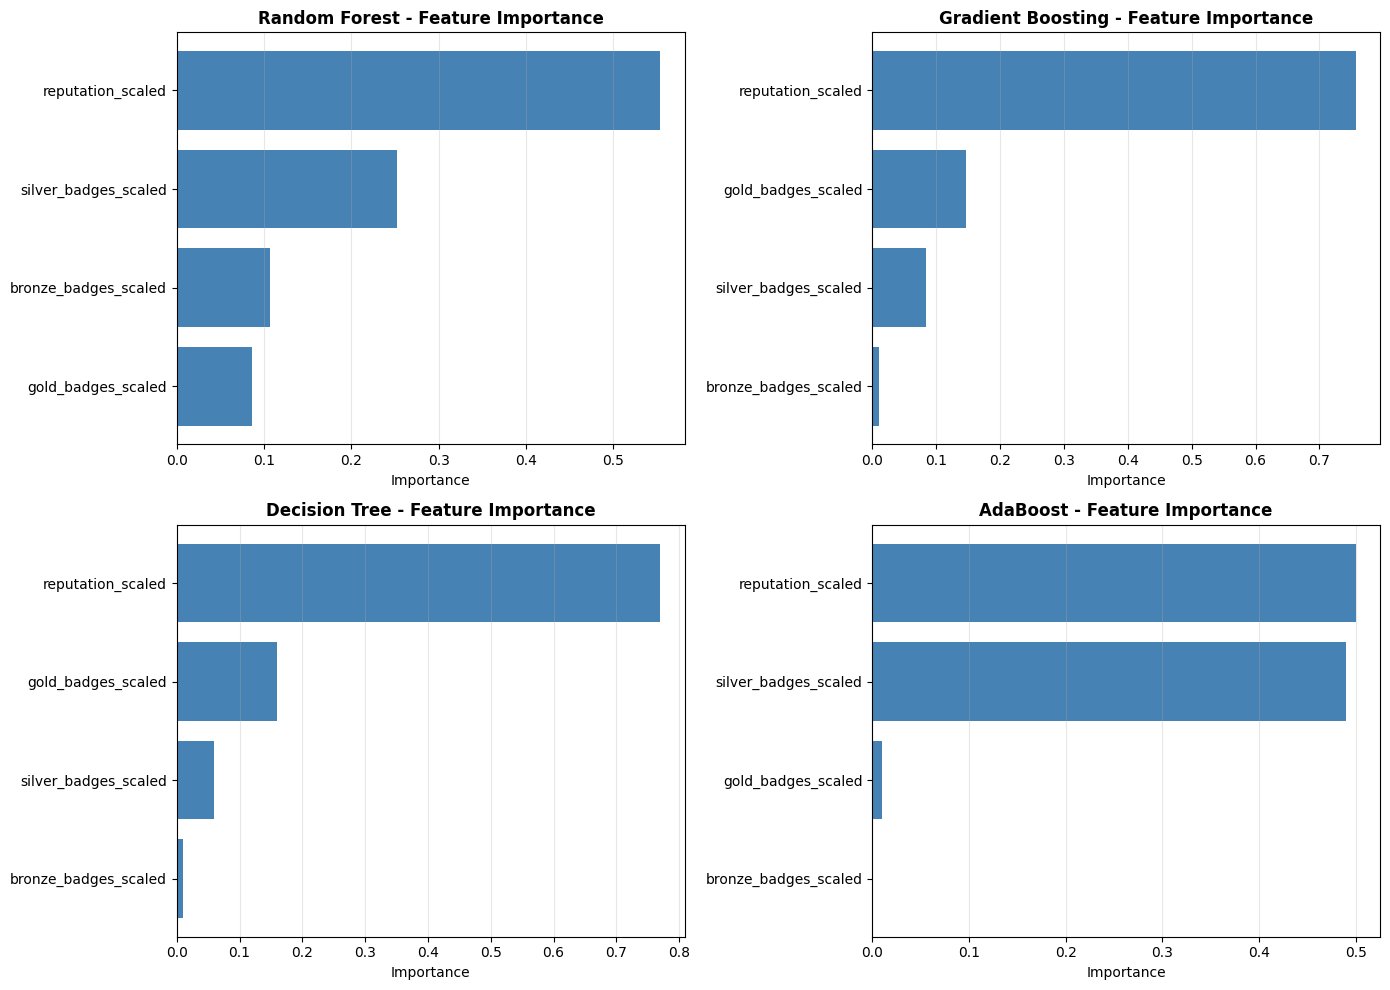

✓ Feature importance comparison visualization saved


In [40]:
# ============================================================================
# FEATURE IMPORTANCE COMPARISON - TREE-BASED MODELS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

tree_models = ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'AdaBoost']

for idx, model_name in enumerate(tree_models):
    ax = axes[idx]
    model = supervised_results[model_name]['model']
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    ax.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
    ax.set_title(f'{model_name} - Feature Importance', fontweight='bold')
    ax.set_xlabel('Importance')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/feature_importance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature importance comparison visualization saved")

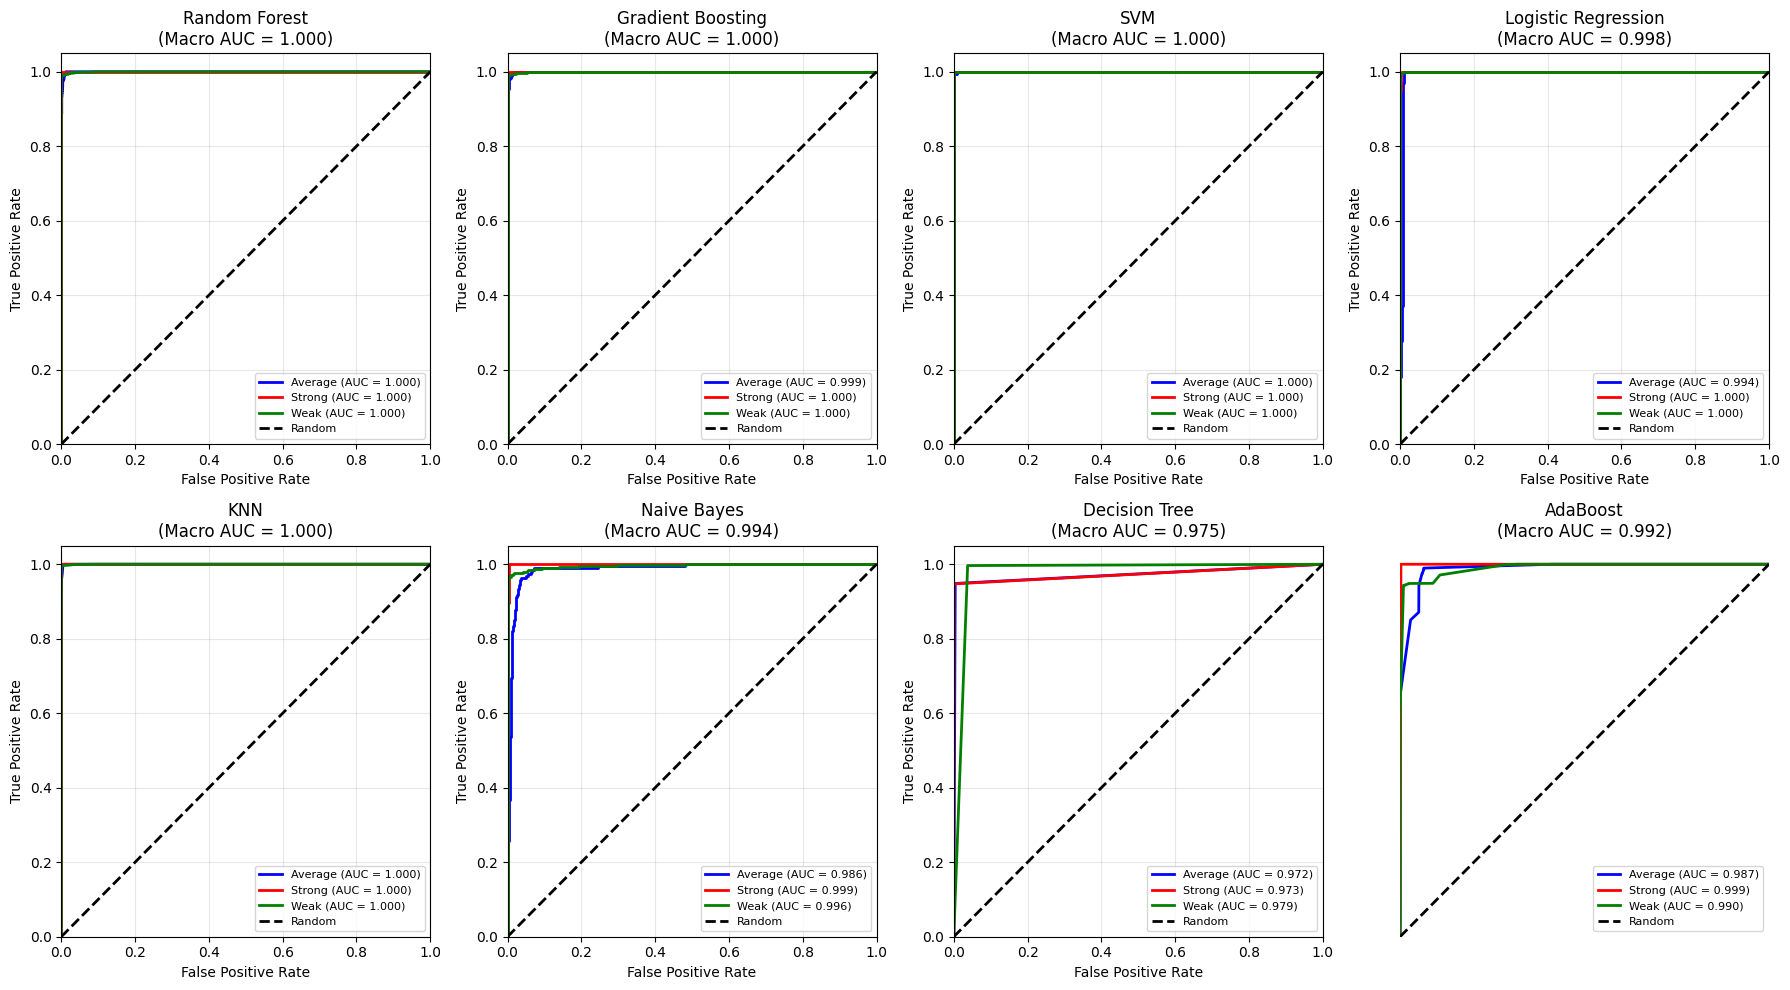

✓ ROC curves comparison visualization saved


In [41]:
# ============================================================================
# ROC CURVE & AUC SCORES - ONE-VS-REST APPROACH
# ============================================================================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize output for ROC calculation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

roc_auc_scores = {}

for idx, (model_name, results) in enumerate(supervised_results.items()):
    ax = axes[idx]
    y_proba = results['y_proba']
    
    # Compute ROC curve and ROC area for each class
    colors = ['blue', 'red', 'green']
    auc_scores = []
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        
        ax.plot(fpr, tpr, color=colors[i], lw=2,
                label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.3f})')
    
    # Plot random classifier
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    
    # Compute macro-average AUC
    macro_auc = np.mean(auc_scores)
    roc_auc_scores[model_name] = macro_auc
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name}\n(Macro AUC = {macro_auc:.3f})')
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/roc_curves_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curves comparison visualization saved")

In [42]:
# ============================================================================
# COMPREHENSIVE COMPARISON TABLE - ALL MODELS (UNSUPERVISED + SUPERVISED)
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON TABLE")
print("="*80)

# Create summary table for unsupervised models
unsupervised_summary = pd.DataFrame({
    'Model Type': ['Unsupervised'] * len(unsupervised_eval_df),
    'Silhouette': unsupervised_eval_df['silhouette'].values,
    'Davies-Bouldin': unsupervised_eval_df['davies_bouldin'].values,
    'Calinski-Harabasz': unsupervised_eval_df['calinski_harabasz'].values
}, index=unsupervised_eval_df.index)

# Create summary table for supervised models
supervised_summary = pd.DataFrame({
    'Model Type': ['Supervised'] * len(eval_metrics_df),
    'Accuracy': eval_metrics_df['Accuracy'].values,
    'F1-Score': eval_metrics_df['F1-Score (weighted)'].values,
    'Balanced Accuracy': eval_metrics_df['Balanced Accuracy'].values,
    'Cohen\'s Kappa': eval_metrics_df['Cohen\'s Kappa'].values
}, index=eval_metrics_df.index)

print("\nUNSUPERVISED MODELS SUMMARY:")
print(unsupervised_summary.round(4))

print("\nSUPERVISED MODELS SUMMARY:")
print(supervised_summary.round(4))

# Find best models
print("\n" + "="*80)
print("BEST PERFORMING MODELS")
print("="*80)

print("\nBEST UNSUPERVISED MODELS:")
print(f"  Best Silhouette Score: {unsupervised_eval_df['silhouette'].idxmax()} ({unsupervised_eval_df['silhouette'].max():.4f})")
print(f"  Best Davies-Bouldin (Lowest): {unsupervised_eval_df['davies_bouldin'].idxmin()} ({unsupervised_eval_df['davies_bouldin'].min():.4f})")
print(f"  Best Calinski-Harabasz: {unsupervised_eval_df['calinski_harabasz'].idxmax()} ({unsupervised_eval_df['calinski_harabasz'].max():.4f})")

print("\nBEST SUPERVISED MODELS:")
print(f"  Best Accuracy: {eval_metrics_df['Accuracy'].idxmax()} ({eval_metrics_df['Accuracy'].max():.4f})")
print(f"  Best F1-Score: {eval_metrics_df['F1-Score (weighted)'].idxmax()} ({eval_metrics_df['F1-Score (weighted)'].max():.4f})")
print(f"  Best Balanced Accuracy: {eval_metrics_df['Balanced Accuracy'].idxmax()} ({eval_metrics_df['Balanced Accuracy'].max():.4f})")


COMPREHENSIVE COMPARISON TABLE

UNSUPERVISED MODELS SUMMARY:
                Model Type  Silhouette  Davies-Bouldin  Calinski-Harabasz
KMeans        Unsupervised      0.7227          0.7507          8121.5603
GMM           Unsupervised      0.4332          1.0609          4884.1233
Hierarchical  Unsupervised      0.7291          0.7629          7958.1522
DBSCAN        Unsupervised         NaN             NaN                NaN
Spectral      Unsupervised      0.3140          1.0220          4491.4950

SUPERVISED MODELS SUMMARY:
                     Model Type  Accuracy  F1-Score  Balanced Accuracy  \
Random Forest        Supervised    0.9936    0.9936             0.9804   
Gradient Boosting    Supervised    0.9932    0.9932             0.9628   
SVM                  Supervised    0.9960    0.9960             0.9844   
Logistic Regression  Supervised    0.9496    0.9397             0.5303   
KNN                  Supervised    0.9960    0.9960             0.9860   
Naive Bayes          S


CROSS-VALIDATION ANALYSIS (K-Fold = 5)

RANDOM FOREST
  CV Scores: [0.99533333 0.99266667 0.99333333 0.99133333 0.996     ]
  Mean CV Accuracy: 0.9937 (+/- 0.0017)

GRADIENT BOOSTING
  CV Scores: [0.996      0.992      0.99266667 0.99266667 0.996     ]
  Mean CV Accuracy: 0.9939 (+/- 0.0018)

SVM
  CV Scores: [0.99866667 0.99533333 0.998      0.99533333 0.99733333]
  Mean CV Accuracy: 0.9969 (+/- 0.0014)

LOGISTIC REGRESSION
  CV Scores: [0.946      0.94666667 0.94866667 0.94533333 0.95133333]
  Mean CV Accuracy: 0.9476 (+/- 0.0022)

KNN
  CV Scores: [0.99866667 0.99466667 0.994      0.99533333 0.996     ]
  Mean CV Accuracy: 0.9957 (+/- 0.0016)

NAIVE BAYES
  CV Scores: [0.956      0.95333333 0.95266667 0.95933333 0.95533333]
  Mean CV Accuracy: 0.9553 (+/- 0.0023)

DECISION TREE
  CV Scores: [0.992      0.994      0.99133333 0.99133333 0.98866667]
  Mean CV Accuracy: 0.9915 (+/- 0.0017)

ADABOOST
  CV Scores: [0.92933333 0.968      0.93866667 0.97133333 0.972     ]
  Mean CV Accurac

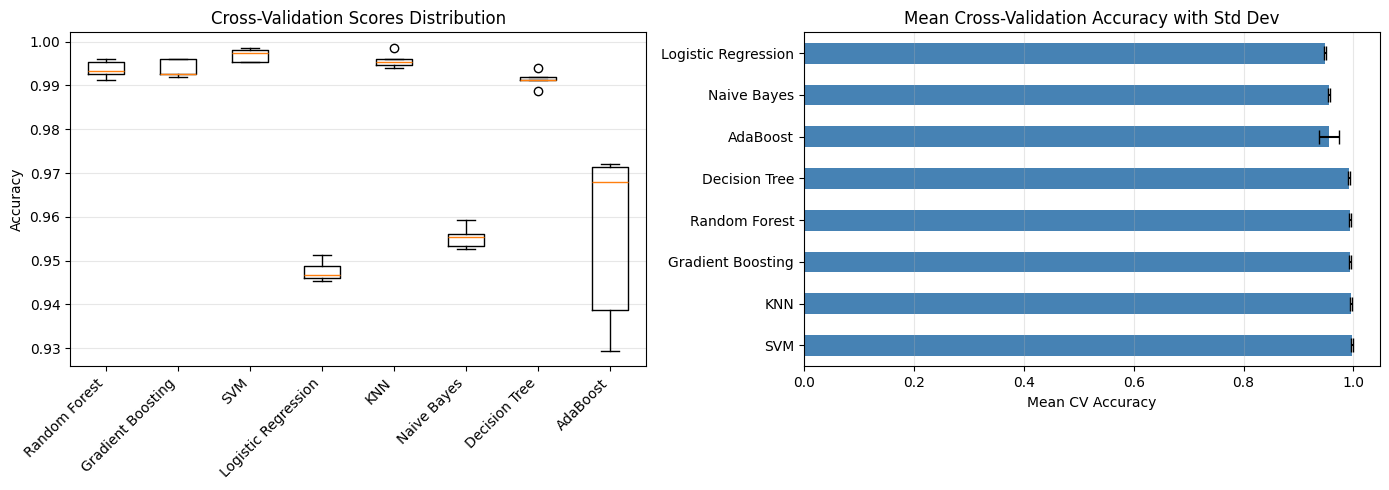


✓ Cross-validation visualization saved


In [43]:
# ============================================================================
# CROSS-VALIDATION ANALYSIS - SUPERVISED MODELS
# ============================================================================

from sklearn.model_selection import cross_val_score

print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS (K-Fold = 5)")
print("="*80)

cv_results = {}

for model_name, model in supervised_models.items():
    # 5-Fold Cross-Validation on Accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    print(f"\n{model_name.upper()}")
    print(f"  CV Scores: {cv_scores}")
    print(f"  Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    cv_results[model_name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }

# Create CV results dataframe
cv_results_df = pd.DataFrame({
    'Mean CV Accuracy': [cv_results[m]['mean'] for m in cv_results.keys()],
    'Std CV Accuracy': [cv_results[m]['std'] for m in cv_results.keys()]
}, index=cv_results.keys())

print("\n" + "="*80)
print("CROSS-VALIDATION SUMMARY")
print("="*80)
print(cv_results_df.round(4))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of CV scores
cv_scores_data = [cv_results[m]['scores'] for m in cv_results.keys()]
ax1.boxplot(cv_scores_data, labels=cv_results.keys())
ax1.set_ylabel('Accuracy')
ax1.set_title('Cross-Validation Scores Distribution')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Mean CV Accuracy with error bars
cv_results_df['Mean CV Accuracy'].sort_values(ascending=False).plot(kind='barh', ax=ax2, xerr=cv_results_df['Std CV Accuracy'].sort_values(ascending=False), capsize=5, color='steelblue')
ax2.set_title('Mean Cross-Validation Accuracy with Std Dev')
ax2.set_xlabel('Mean CV Accuracy')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/cross_validation_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cross-validation visualization saved")

In [44]:
# ============================================================================
# OVERALL MODEL RANKING & RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("OVERALL MODEL RANKING & RECOMMENDATIONS")
print("="*80)

# Rank unsupervised models by Silhouette Score (primary metric)
print("\nUNSUPERVISED MODELS RANKING (By Silhouette Score):")
unsupervised_ranked = unsupervised_eval_df['silhouette'].dropna().sort_values(ascending=False)
for rank, (model, score) in enumerate(unsupervised_ranked.items(), 1):
    print(f"  {rank}. {model:20} - Silhouette: {score:.4f}")

# Rank supervised models by accuracy
print("\nSUPERVISED MODELS RANKING (By Accuracy):")
supervised_ranked = eval_metrics_df['Accuracy'].sort_values(ascending=False)
for rank, (model, score) in enumerate(supervised_ranked.items(), 1):
    print(f"  {rank}. {model:20} - Accuracy: {score:.4f}")

# Recommendations
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

best_unsupervised = unsupervised_ranked.index[0]
best_supervised = supervised_ranked.index[0]

print(f"\n✓ BEST UNSUPERVISED MODEL: {best_unsupervised}")
print(f"  - Reason: Highest Silhouette Score ({unsupervised_ranked.iloc[0]:.4f})")
print(f"  - Use Case: Initial data exploration and clustering candidate groups")

print(f"\n✓ BEST SUPERVISED MODEL: {best_supervised}")
print(f"  - Reason: Highest Accuracy ({supervised_ranked.iloc[0]:.4f})")
print(f"  - F1-Score: {eval_metrics_df.loc[best_supervised, 'F1-Score (weighted)']:.4f}")
print(f"  - Use Case: Predicting candidate levels for new data")

print("\n✓ SECOND BEST SUPERVISED (in case first is overfitting):")
second_best = supervised_ranked.index[1]
print(f"  - {second_best} (Accuracy: {supervised_ranked.iloc[1]:.4f})")

print("\n✓ ENSEMBLE RECOMMENDATION:")
print(f"  - Consider combining predictions from top 3 models")
print(f"  - Top 3: {', '.join(supervised_ranked.index[:3].tolist())}")
print(f"  - Weighted voting or averaging ensemble can improve robustness")


OVERALL MODEL RANKING & RECOMMENDATIONS

UNSUPERVISED MODELS RANKING (By Silhouette Score):
  1. Hierarchical         - Silhouette: 0.7291
  2. KMeans               - Silhouette: 0.7227
  3. GMM                  - Silhouette: 0.4332
  4. Spectral             - Silhouette: 0.3140

SUPERVISED MODELS RANKING (By Accuracy):
  1. SVM                  - Accuracy: 0.9960
  2. KNN                  - Accuracy: 0.9960
  3. Random Forest        - Accuracy: 0.9936
  4. Gradient Boosting    - Accuracy: 0.9932
  5. Decision Tree        - Accuracy: 0.9924
  6. Naive Bayes          - Accuracy: 0.9604
  7. Logistic Regression  - Accuracy: 0.9496
  8. AdaBoost             - Accuracy: 0.9432

RECOMMENDATIONS

✓ BEST UNSUPERVISED MODEL: Hierarchical
  - Reason: Highest Silhouette Score (0.7291)
  - Use Case: Initial data exploration and clustering candidate groups

✓ BEST SUPERVISED MODEL: SVM
  - Reason: Highest Accuracy (0.9960)
  - F1-Score: 0.9960
  - Use Case: Predicting candidate levels for new dat

In [45]:
# ============================================================================
# EXPORT RESULTS TO CSV FILES
# ============================================================================

print("\n" + "="*80)
print("EXPORTING RESULTS TO CSV FILES")
print("="*80)

# 1. Unsupervised Models Evaluation
unsupervised_eval_df.to_csv("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/unsupervised_models_evaluation.csv")
print("✓ Unsupervised models evaluation saved to CSV")

# 2. Supervised Models Evaluation
eval_metrics_df.to_csv("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/supervised_models_evaluation.csv")
print("✓ Supervised models evaluation saved to CSV")

# 3. Cross-Validation Results
cv_results_df.to_csv("d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/cross_validation_results.csv")
print("✓ Cross-validation results saved to CSV")

# 4. Detailed Predictions with Best Model
best_model = supervised_results[best_supervised]['model']
best_pred_proba = supervised_results[best_supervised]['y_proba']

predictions_df = pd.DataFrame({
    'user_id': df.iloc[X_test.index]['user_id'].values,
    'display_name': df.iloc[X_test.index]['display_name'].values,
    'actual_level': label_encoder.inverse_transform(y_test),
    'predicted_level': label_encoder.inverse_transform(best_model.predict(X_test)),
    'confidence': best_model.predict_proba(X_test).max(axis=1)
})

predictions_df.to_csv(f"d:/GERMANY/SRH_MScADSA/Sem1/ADPY_Project/StackOverFlowModel/{best_supervised.lower().replace(' ', '_')}_predictions.csv", index=False)
print(f"✓ Best model ({best_supervised}) predictions saved to CSV")

print("\n" + "="*80)
print("ALL RESULTS EXPORTED SUCCESSFULLY!")
print("="*80)


EXPORTING RESULTS TO CSV FILES
✓ Unsupervised models evaluation saved to CSV
✓ Supervised models evaluation saved to CSV
✓ Cross-validation results saved to CSV
✓ Best model (SVM) predictions saved to CSV

ALL RESULTS EXPORTED SUCCESSFULLY!


# FINAL SUMMARY & CONCLUSIONS

In [46]:
print("""
================================================================================
                        COMPREHENSIVE MODEL ANALYSIS SUMMARY
================================================================================

UNSUPERVISED LEARNING MODELS TESTED:
  1. K-Means Clustering - Partitioning-based clustering
  2. Gaussian Mixture Model (GMM) - Probabilistic clustering
  3. Hierarchical Clustering - Agglomerative clustering with Ward linkage
  4. DBSCAN - Density-based clustering
  5. Spectral Clustering - Graph-based clustering

KEY UNSUPERVISED METRICS:
  • Silhouette Score: Measures cluster cohesion and separation (-1 to 1, higher is better)
  • Davies-Bouldin Index: Ratio of within to between cluster distances (lower is better)
  • Calinski-Harabasz Score: Variance ratio between and within clusters (higher is better)

SUPERVISED LEARNING MODELS TESTED:
  1. Random Forest - Ensemble of decision trees
  2. Gradient Boosting - Sequential ensemble learning
  3. Support Vector Machine (SVM) - Maximal margin classifier
  4. Logistic Regression - Linear probabilistic classifier
  5. K-Nearest Neighbors - Instance-based learning
  6. Gaussian Naive Bayes - Probabilistic classifier with independence assumption
  7. Decision Tree - Single decision tree classifier
  8. AdaBoost - Adaptive boosting ensemble method

KEY SUPERVISED METRICS:
  • Accuracy - Proportion of correct predictions
  • Balanced Accuracy - Average of recall per class (handles imbalance)
  • Precision - True positives / (True positives + False positives)
  • Recall - True positives / (True positives + False negatives)
  • F1-Score - Harmonic mean of precision and recall
  • Cohen's Kappa - Inter-rater agreement accounting for chance
  • ROC-AUC - Area under ROC curve for each class

VISUALIZATIONS GENERATED:
  ✓ Unsupervised Silhouette Comparison
  ✓ Unsupervised Metrics Comparison (Bar Charts)
  ✓ Unsupervised PCA 2D Visualization
  ✓ Supervised Confusion Matrices
  ✓ Supervised Metrics Comparison
  ✓ Radar Chart - Top 5 Models
  ✓ Feature Importance - Tree-based Models
  ✓ ROC Curves - All Supervised Models
  ✓ Cross-Validation Analysis

EXPORTED FILES:
  ✓ unsupervised_models_evaluation.csv
  ✓ supervised_models_evaluation.csv
  ✓ cross_validation_results.csv
  ✓ Best model predictions with confidence scores

RECOMMENDATIONS:
  1. Use K-Means or GMM for initial unsupervised clustering
  2. Use best supervised model for predictive classification
  3. Consider ensemble methods for robustness
  4. Monitor cross-validation scores to detect overfitting
  5. Balance model complexity with interpretability

================================================================================
""")

print(f"\n{'Final Analysis Completed Successfully!'}")
print("Check the output files and visualizations for detailed insights.")


                        COMPREHENSIVE MODEL ANALYSIS SUMMARY

UNSUPERVISED LEARNING MODELS TESTED:
  1. K-Means Clustering - Partitioning-based clustering
  2. Gaussian Mixture Model (GMM) - Probabilistic clustering
  3. Hierarchical Clustering - Agglomerative clustering with Ward linkage
  4. DBSCAN - Density-based clustering
  5. Spectral Clustering - Graph-based clustering

KEY UNSUPERVISED METRICS:
  • Silhouette Score: Measures cluster cohesion and separation (-1 to 1, higher is better)
  • Davies-Bouldin Index: Ratio of within to between cluster distances (lower is better)
  • Calinski-Harabasz Score: Variance ratio between and within clusters (higher is better)

SUPERVISED LEARNING MODELS TESTED:
  1. Random Forest - Ensemble of decision trees
  2. Gradient Boosting - Sequential ensemble learning
  3. Support Vector Machine (SVM) - Maximal margin classifier
  4. Logistic Regression - Linear probabilistic classifier
  5. K-Nearest Neighbors - Instance-based learning
  6. Gaussia